# 2018 Yellow Taxi Trip Data Analysis

- Importing python library
- Read taxi-sample and shape files
- Data cleaning (removing null values, trip duration 0 etc.)
- Insights on different attributes

In [1]:
import pandas as pd
import numpy as np
import time
import shapefile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
import math

### Loading taxi-sample data

In [2]:
startTime = time.time()
taxiSample = pd.read_csv("data/taxi-sample.csv")
taxiSample[105:110]

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
105         2  03/12/2019 11:12:48 PM  03/12/2019 11:23:38 PM   
106         2  03/07/2019 06:25:03 AM  03/07/2019 03:25:31 PM   
107         2  03/04/2019 12:35:59 PM  03/04/2019 01:07:03 PM   
108         2  03/04/2019 12:13:56 AM  03/04/2019 12:32:39 AM   
109         2  03/03/2019 03:27:20 AM  03/03/2019 12:01:14 PM   

     passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
105                1           1.10           1                  N   
106                1           8.66           1                  N   
107                2           5.52           1                  N   
108                5          11.94           1                  N   
109                1           6.37           1                  N   

     PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
105           137           113             1          8.5    0.0      0.5   
106           163            54             1         38.0    0.0      0.5   
107            50           179             1         23.0    0.0      0.5   
108            70           265             2         32.5    0.0      0.5   
109           170            13             1         27.0    0.0      0.5   

     tip_amount  tolls_amount  improvement_surcharge  total_amount  
105        1.86           0.0                    0.3         11.16  
106        7.76           0.0                    0.3         46.56  
107        0.00           0.0                    0.3         23.80  
108        0.00           0.0                    0.3         33.30  
109        4.50           0.0                    0.3         32.30

### Update datetime column to 24 hour format and adding columns for hour, week, month etc.

In [3]:
%%time
taxiSample['tpep_pickup_datetime'] = pd.to_datetime(taxiSample['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
taxiSample['tpep_dropoff_datetime'] = pd.to_datetime(taxiSample['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 7.23 s, sys: 37 ms, total: 7.27 s
Wall time: 7.3 s


In [4]:
taxiSample["pickup_date"] = taxiSample.tpep_pickup_datetime.dt.day
taxiSample["pickup_dayofweek"] = taxiSample.tpep_pickup_datetime.dt.weekday
taxiSample["pickup_weekday"] = taxiSample.tpep_pickup_datetime.dt.weekday_name
taxiSample["pickup_hour"] = taxiSample.tpep_pickup_datetime.dt.hour
taxiSample["pickup_month"] = taxiSample.tpep_pickup_datetime.dt.month
taxiSample["pickup_year"] = taxiSample.tpep_pickup_datetime.dt.year

In [5]:
taxiSample["dropoff_date"] = taxiSample.tpep_dropoff_datetime.dt.day
taxiSample["dropoff_weekday"] = taxiSample.tpep_dropoff_datetime.dt.weekday_name
taxiSample["dropoff_hour"] = taxiSample.tpep_dropoff_datetime.dt.hour
taxiSample["dropoff_month"] = taxiSample.tpep_dropoff_datetime.dt.month
taxiSample["dropoff_year"] = taxiSample.tpep_dropoff_datetime.dt.year

In [6]:
print(taxiSample.shape)
taxiSample[105:110]

(1048576, 28)


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
105         2  2019-03-12 23:12:48   2019-03-12 23:23:38                1   
106         2  2019-03-07 06:25:03   2019-03-07 15:25:31                1   
107         2  2019-03-04 12:35:59   2019-03-04 13:07:03                2   
108         2  2019-03-04 00:13:56   2019-03-04 00:32:39                5   
109         2  2019-03-03 03:27:20   2019-03-03 12:01:14                1   

     trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
105           1.10           1                  N           137           113   
106           8.66           1                  N           163            54   
107           5.52           1                  N            50           179   
108          11.94           1                  N            70           265   
109           6.37           1                  N           170            13   

     payment_type  ...  pickup_dayofweek  pickup_weekday  pickup_hour  \
105             1  ...                 1         Tuesday           23   
106             1  ...                 3        Thursday            6   
107             1  ...                 0          Monday           12   
108             2  ...                 0          Monday            0   
109             1  ...                 6          Sunday            3   

     pickup_month  pickup_year  dropoff_date  dropoff_weekday  dropoff_hour  \
105             3         2019            12          Tuesday            23   
106             3         2019             7         Thursday            15   
107             3         2019             4           Monday            13   
108             3         2019             4           Monday             0   
109             3         2019             3           Sunday            12   

     dropoff_month dropoff_year  
105              3         2019  
106              3         2019  
107              3         2019  
108              3         2019  
109              3         2019  

[5 rows x 28 columns]

### Loading shape file

In [7]:
taxiZonesShape = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in taxiZonesShape.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = taxiZonesShape.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

### Methods for displaying the map

In [8]:
def get_lat_lon(taxiZones):
    content = []
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [9]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [10]:
def draw_region_map(ax, taxiZones, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_x = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    reg_y = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values())))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center',
                     verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5),
                     color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000),
                     horizontalalignment='center', verticalalignment='center',
                     bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=12)       

    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [11]:
def draw_zone_map(ax, taxiZones, heat={}, text=[], arrows=[]):
    continent = [180/256, 50/256, 50/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=8,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [12]:
taxiZone = pd.DataFrame(shp_attr).join(get_lat_lon(taxiZonesShape).set_index("LocationID"), on="LocationID")
zone_dic = dict(zip(taxiZone.LocationID, taxiZone.zone))
borough_dic = dict(zip(taxiZone.LocationID, taxiZone.borough))
zones = taxiZone['zone'].unique()
boroughs = taxiZone['borough'].unique()
temp = dict(enumerate(boroughs.flatten(), 1))
reg_list = dict([(value, key) for key, value in temp.items()])
print(reg_list)
taxiZone.head()

{'EWR': 1, 'Queens': 2, 'Bronx': 3, 'Manhattan': 4, 'Staten Island': 5, 'Brooklyn': 6}


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough     longitude       latitude  
0            EWR  9.366817e+05  190522.130278  
1         Queens  1.033536e+06  161853.982300  
2          Bronx  1.027136e+06  254730.010849  
3      Manhattan  9.904240e+05  203100.040432  
4  Staten Island  9.321332e+05  139954.541936

### Show the boroughs and zones of New York City

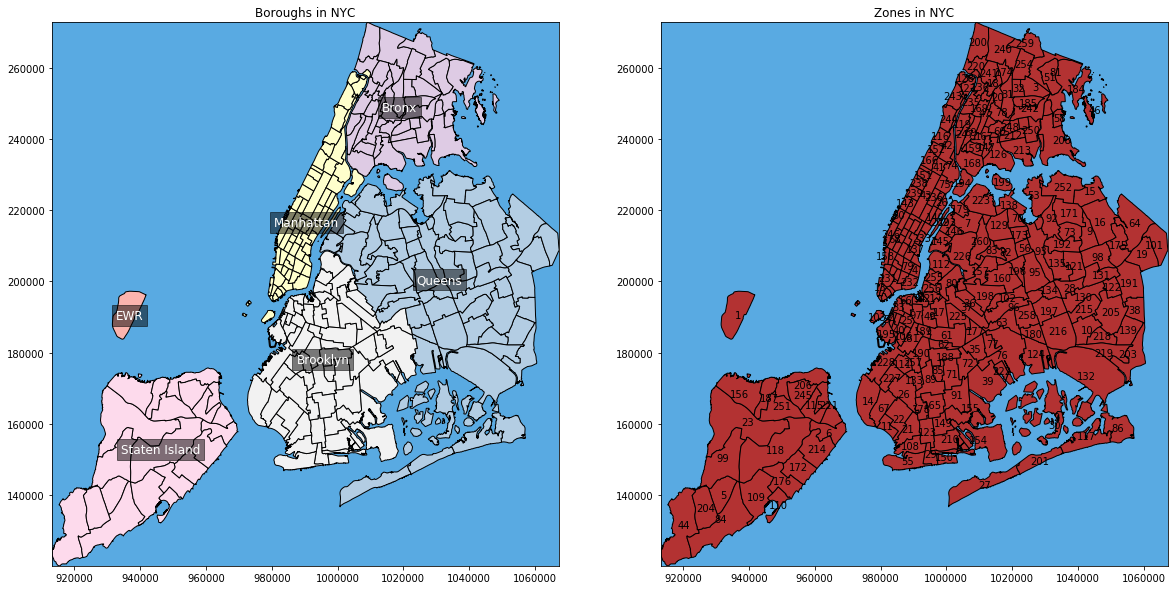

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, taxiZonesShape)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, taxiZonesShape)

## Data Cleaning

### Checking if there is any null value in the dataset

In [14]:
taxiSample.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
pickup_date              False
pickup_dayofweek         False
pickup_weekday           False
pickup_hour              False
pickup_month             False
pickup_year              False
dropoff_date             False
dropoff_weekday          False
dropoff_hour             False
dropoff_month            False
dropoff_year             False
dtype: bool

### Removing rows with trip distance 0 or less

In [15]:
trip_dist = taxiSample[taxiSample.trip_distance <= 0.0]
trip_dist.shape

(8463, 28)

In [16]:
taxiSample = taxiSample[taxiSample.trip_distance > 0.0]
taxiSample.shape

(1040113, 28)

### Removing rows with passenger count 0 or less

In [17]:
pass_count = taxiSample[taxiSample.passenger_count <= 0]
pass_count.shape

(15039, 28)

In [18]:
taxiSample = taxiSample[taxiSample.passenger_count > 0]
taxiSample.shape

(1025074, 28)

### Removing duplicate rows

In [19]:
duplicate = taxiSample[taxiSample.duplicated()]
duplicate.shape

(21, 28)

In [20]:
taxiSample.drop_duplicates(keep='first', inplace=True)
taxiSample.shape

(1025053, 28)

### Removing rows with same pickup and dropoff time

In [21]:
same_pick_drop = taxiSample[taxiSample.tpep_pickup_datetime==taxiSample.tpep_dropoff_datetime]
same_pick_drop.shape

(46, 28)

In [22]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime!=taxiSample.tpep_dropoff_datetime]
taxiSample.shape

(1025007, 28)

### Removing rows with future dates

In [23]:
print("Train dataset start date: ", min(taxiSample["tpep_pickup_datetime"]))
print("Train dataset end date: ", max(taxiSample["tpep_dropoff_datetime"]))

Train dataset start date:  2018-12-27 00:05:14
Train dataset end date:  2084-11-04 12:47:41


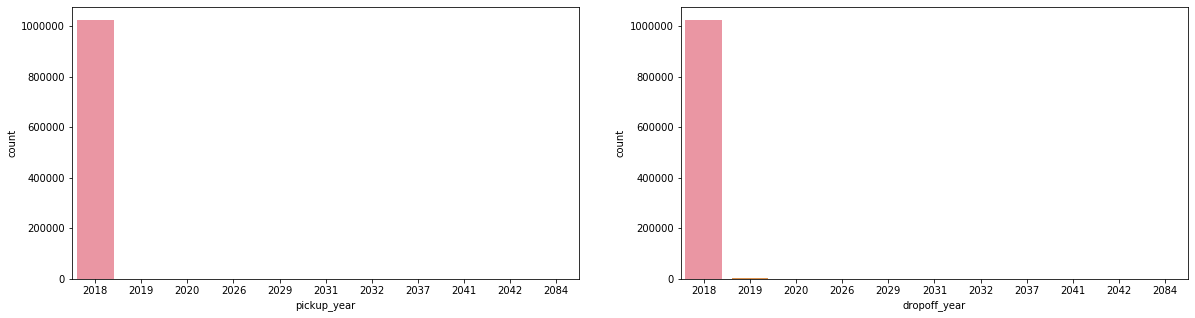

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

In [25]:
taxiSample.groupby('pickup_year')['pickup_year'].count()

pickup_year
2018    1024804
2019        175
2020         10
2026          2
2029          2
2031          2
2032          1
2037          1
2041          1
2042          1
2084          8
Name: pickup_year, dtype: int64

#### We are assuming limit for date is: "2019-06-30 23:59:59" and remove all the future dates

In [26]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime<="2019-06-30 23:59:59"]
taxiSample.shape

(1024969, 28)

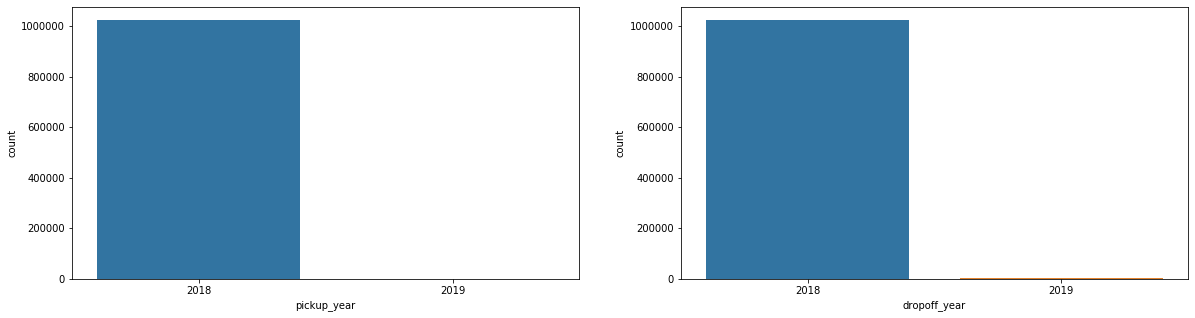

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

### Removing rows that have RatecodeID>6

In [28]:
ratecode_count = taxiSample.groupby('RatecodeID')['RatecodeID'].count()
ratecode_count

RatecodeID
1     991516
2      25862
3       1674
4        652
5       5253
6          2
99        10
Name: RatecodeID, dtype: int64

In [29]:
taxiSample = taxiSample[taxiSample.RatecodeID<=6]
taxiSample.shape

(1024959, 28)

### Checking amounts for negative or zero values

In [30]:
taxiSample[taxiSample.fare_amount<=0.0].shape

(1029, 28)

In [31]:
taxiSample[taxiSample.tip_amount<0.0].shape

(5, 28)

In [32]:
taxiSample[taxiSample.tolls_amount<0.0].shape

(17, 28)

In [33]:
taxiSample[taxiSample.total_amount<=0.0].shape

(902, 28)

In [34]:
taxiSample[taxiSample.extra<0.0].shape

(440, 28)

In [35]:
taxiSample[taxiSample.mta_tax<0.0].shape

(856, 28)

In [36]:
taxiSample[taxiSample.improvement_surcharge<0.0].shape

(871, 28)

In [37]:
taxiSample = taxiSample[taxiSample.fare_amount>0.0]
taxiSample = taxiSample[taxiSample.tip_amount>=0.0]
taxiSample = taxiSample[taxiSample.tolls_amount>=0.0]
taxiSample = taxiSample[taxiSample.total_amount>0.0]
taxiSample = taxiSample[taxiSample.extra>=0.0]
taxiSample = taxiSample[taxiSample.mta_tax>=0.0]
taxiSample = taxiSample[taxiSample.improvement_surcharge>=0.0]
taxiSample.shape

(1023929, 28)

### Removing rows that has LocationID > 263 or < 1, as we don't have shape for those zones

In [38]:
taxiSample[taxiSample.PULocationID>263].shape

(16443, 28)

In [39]:
taxiSample[taxiSample.DOLocationID>263].shape

(17072, 28)

In [40]:
taxiSample = taxiSample[taxiSample.PULocationID<=263]

In [41]:
taxiSample = taxiSample[taxiSample.DOLocationID<=263]

# Insights on different attributes

## Vendor

### Which vendor is most popular overall?

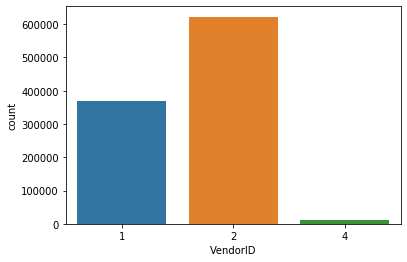

In [42]:
sns.countplot(x="VendorID", data=taxiSample)

In [43]:
taxiSample.groupby('VendorID')['VendorID'].count()

VendorID
1    370427
2    622408
4     12007
Name: VendorID, dtype: int64

### Which Vendor is popular in each region?

          borough  VendorID   count
0           Bronx         1     581
1           Bronx         2    1624
2           Bronx         4       5
3        Brooklyn         1    4250
4        Brooklyn         2    8425
5        Brooklyn         4     104
6             EWR         1      14
7             EWR         2      12
8       Manhattan         1  341584
9       Manhattan         2  561923
10      Manhattan         4   10764
11         Queens         1   24049
12         Queens         2   50588
13         Queens         4    1134
14  Staten Island         1      10
15  Staten Island         2      40


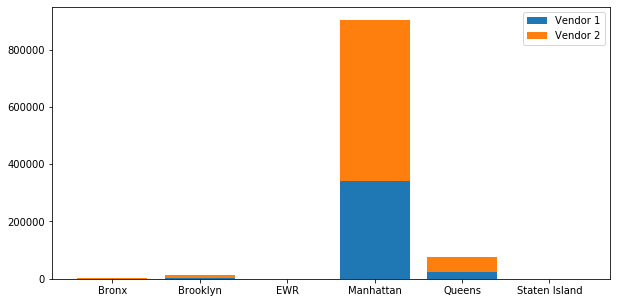

In [44]:
result = taxiSample.groupby(['VendorID','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','VendorID'])['count'].sum().reset_index(name='count')
print(groupResult)
vendor1 = groupResult[groupResult.VendorID==1]['count']
vendor2 = groupResult[groupResult.VendorID==2]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), vendor1, label = "Vendor 1")
ax.bar(groupResult['borough'].unique(), vendor2, bottom=vendor1, label = "Vendor 2")
ax.legend()

## Passenger

### What is the most frequent passenger count?

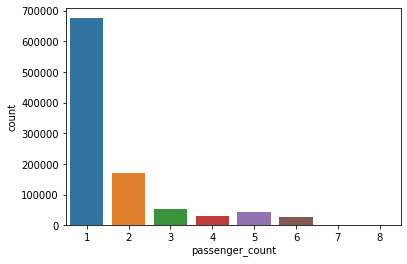

In [45]:
sns.countplot(x="passenger_count", data=taxiSample)

In [46]:
taxiSample.groupby('passenger_count')['passenger_count'].count()

passenger_count
1    674980
2    171178
3     54857
4     31747
5     44704
6     27373
7         1
8         2
Name: passenger_count, dtype: int64

## Store and Forward trip

### What is the percentage of store and forward trip?

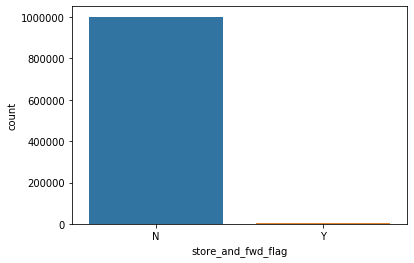

In [47]:
sns.countplot(x="store_and_fwd_flag", data=taxiSample)

In [48]:
taxiSample.groupby('store_and_fwd_flag')['store_and_fwd_flag'].count()

store_and_fwd_flag
N    1001247
Y       3595
Name: store_and_fwd_flag, dtype: int64

In [49]:
temp_flag = taxiSample[taxiSample.store_and_fwd_flag=='N']
(temp_flag.shape[0]*100) / taxiSample.shape[0]  # percentage of record that are N

99.64223231114941

### Which region has the most store and forward trip?

{'EWR': 2, 'Queens': 272, 'Bronx': 15, 'Manhattan': 3250, 'Staten Island': 2, 'Brooklyn': 54}


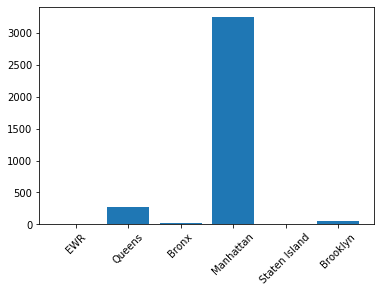

In [50]:
flagCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    flagCount[borough] = totalRideBorough[totalRideBorough.store_and_fwd_flag=='Y']['store_and_fwd_flag'].count()
print(flagCount)
plt.bar(range(len(flagCount)), list(flagCount.values()), align='center')
plt.xticks(range(len(flagCount)), list(flagCount.keys()), rotation=45)

plt.show()

## Payment method

### What is the most popular payment method?

payment_type is a numeric code signifying how the passenger paid for the trip:

* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute

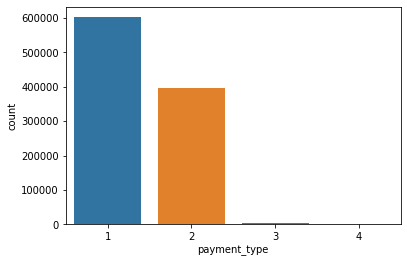

In [51]:
sns.countplot(x="payment_type", data=taxiSample)

In [52]:
taxiSample.groupby('payment_type')['payment_type'].count()

payment_type
1    602108
2    397374
3      3928
4      1432
Name: payment_type, dtype: int64

### Which Payment Type is popular in each region?

          borough  payment_type   count
0           Bronx             1    1521
1           Bronx             2     668
2           Bronx             3      15
3           Bronx             4       6
4        Brooklyn             1    7954
5        Brooklyn             2    4721
6        Brooklyn             3      82
7        Brooklyn             4      22
8             EWR             1      15
9             EWR             2      10
10            EWR             3       1
11      Manhattan             1  543873
12      Manhattan             2  365692
13      Manhattan             3    3450
14      Manhattan             4    1256
15         Queens             1   48891
16         Queens             2   26349
17         Queens             3     383
18         Queens             4     148
19  Staten Island             1      33
20  Staten Island             2      15
21  Staten Island             3       2


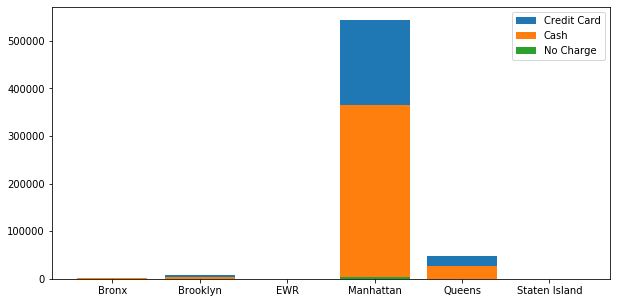

In [53]:
result = taxiSample.groupby(['payment_type','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','payment_type'])['count'].sum().reset_index(name='count')
print(groupResult)
payment1 = groupResult[groupResult.payment_type==1]['count']
payment2 = groupResult[groupResult.payment_type==2]['count']
payment3 = groupResult[groupResult.payment_type==3]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), payment1, label = "Credit Card")
ax.bar(groupResult['borough'].unique(), payment2, label = "Cash")
ax.bar(groupResult['borough'].unique(), payment3, label = "No Charge")
ax.legend()

* We can see that EWR and Shaten Island has no Dispute payment type

## Fare and Tip amount

### What is the rate of tip?

In [54]:
no_tip = taxiSample[taxiSample.tip_amount==0]
no_tip.shape

(435176, 28)

In [55]:
tip = taxiSample[taxiSample.tip_amount>0]
tip.shape

(569666, 28)

In [56]:
(tip.shape[0]*100) / (no_tip.shape[0] + tip.shape[0])  # percentage of passenger that tips

56.69209686697013

### What is the relation between fareAmount and tip?

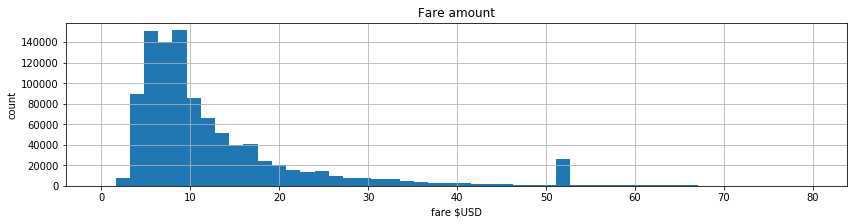

In [57]:
taxiSample[taxiSample.fare_amount<80].fare_amount.hist(bins=50, figsize=(14,3))
plt.xlabel('fare $USD')
plt.ylabel('count')
plt.title('Fare amount');

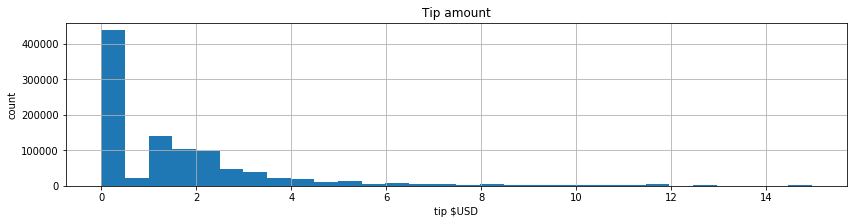

In [58]:
taxiSample[taxiSample.tip_amount<15].tip_amount.hist(bins=30, figsize=(14,3))
plt.xlabel('tip $USD')
plt.ylabel('count')
plt.title('Tip amount');

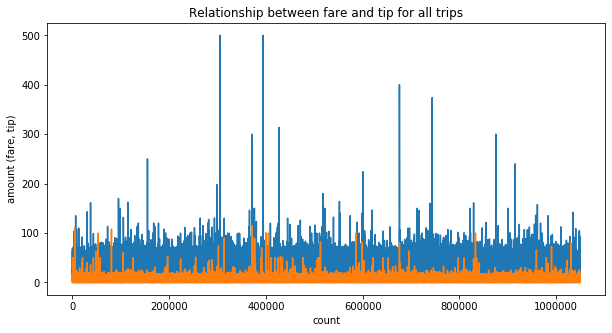

In [59]:
fare_tip = taxiSample[['fare_amount','tip_amount']]
plt.figure(figsize=(10,5))
plt.plot(fare_tip)
plt.title('Relationship between fare and tip for all trips')
plt.xlabel('count')
plt.ylabel('amount (fare, tip)')
plt.show()

## Tolls amount

### Which region has the most trips that includes a bridge? i.e. toll~bridge

{'EWR': 6, 'Queens': 32933, 'Bronx': 414, 'Manhattan': 18658, 'Staten Island': 16, 'Brooklyn': 595}


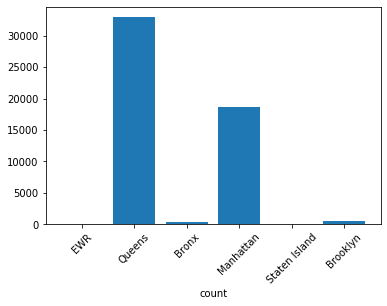

In [60]:
tollsCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    tollsCount[borough] = totalRideBorough[totalRideBorough.tolls_amount>0]['tolls_amount'].count()
print(tollsCount)
plt.bar(range(len(tollsCount)), list(tollsCount.values()), align='center')
plt.xticks(range(len(tollsCount)), list(tollsCount.keys()), rotation=45)
plt.xlabel('count')
plt.show()

## Pickup and Dropoff time

### Which day of the week has most pickup/dropoff?

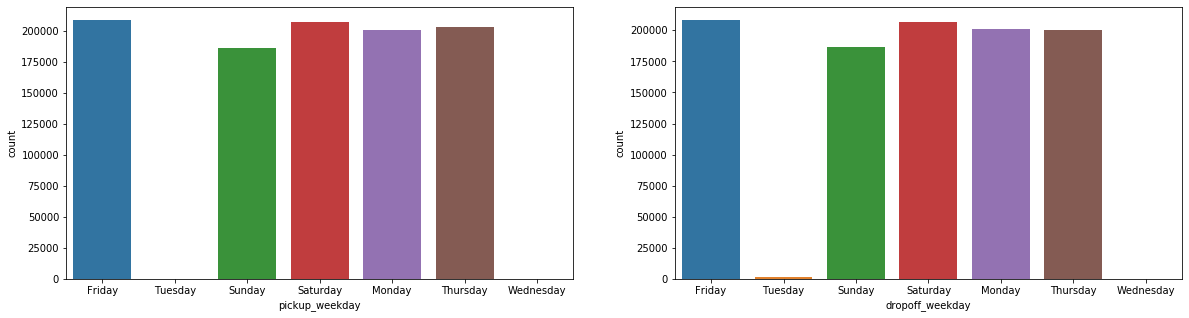

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_weekday", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_weekday", data=taxiSample, ax=ax[1])
plt.show()

### Which time of the day has most pickup/dropoff?

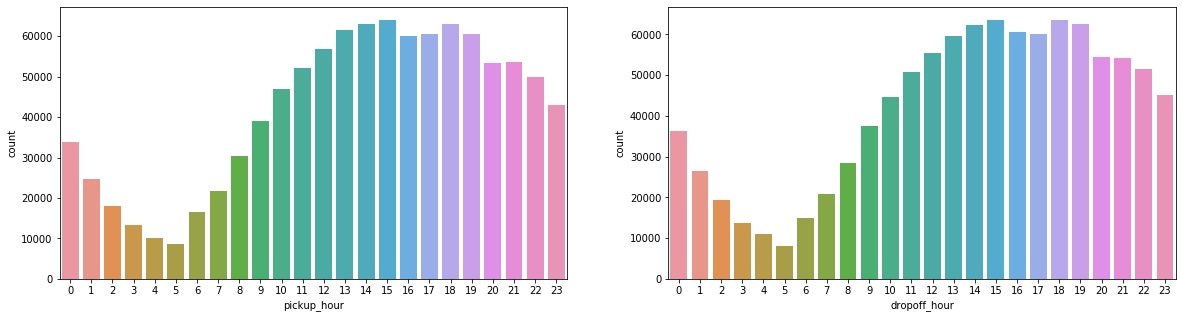

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_hour", data=taxiSample, ax=ax[1])
plt.show()

### Which month has the most pickup/dropoff?

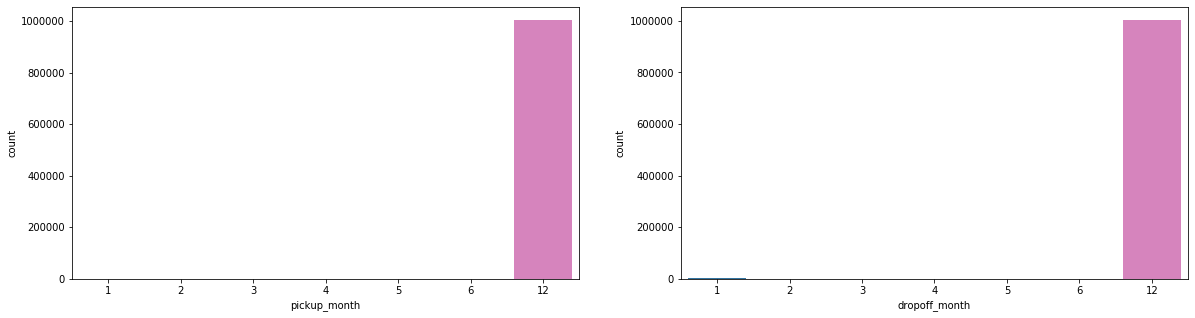

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_month", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_month", data=taxiSample, ax=ax[1])
plt.show()

### What is the busiest hour in each borough of New York City?

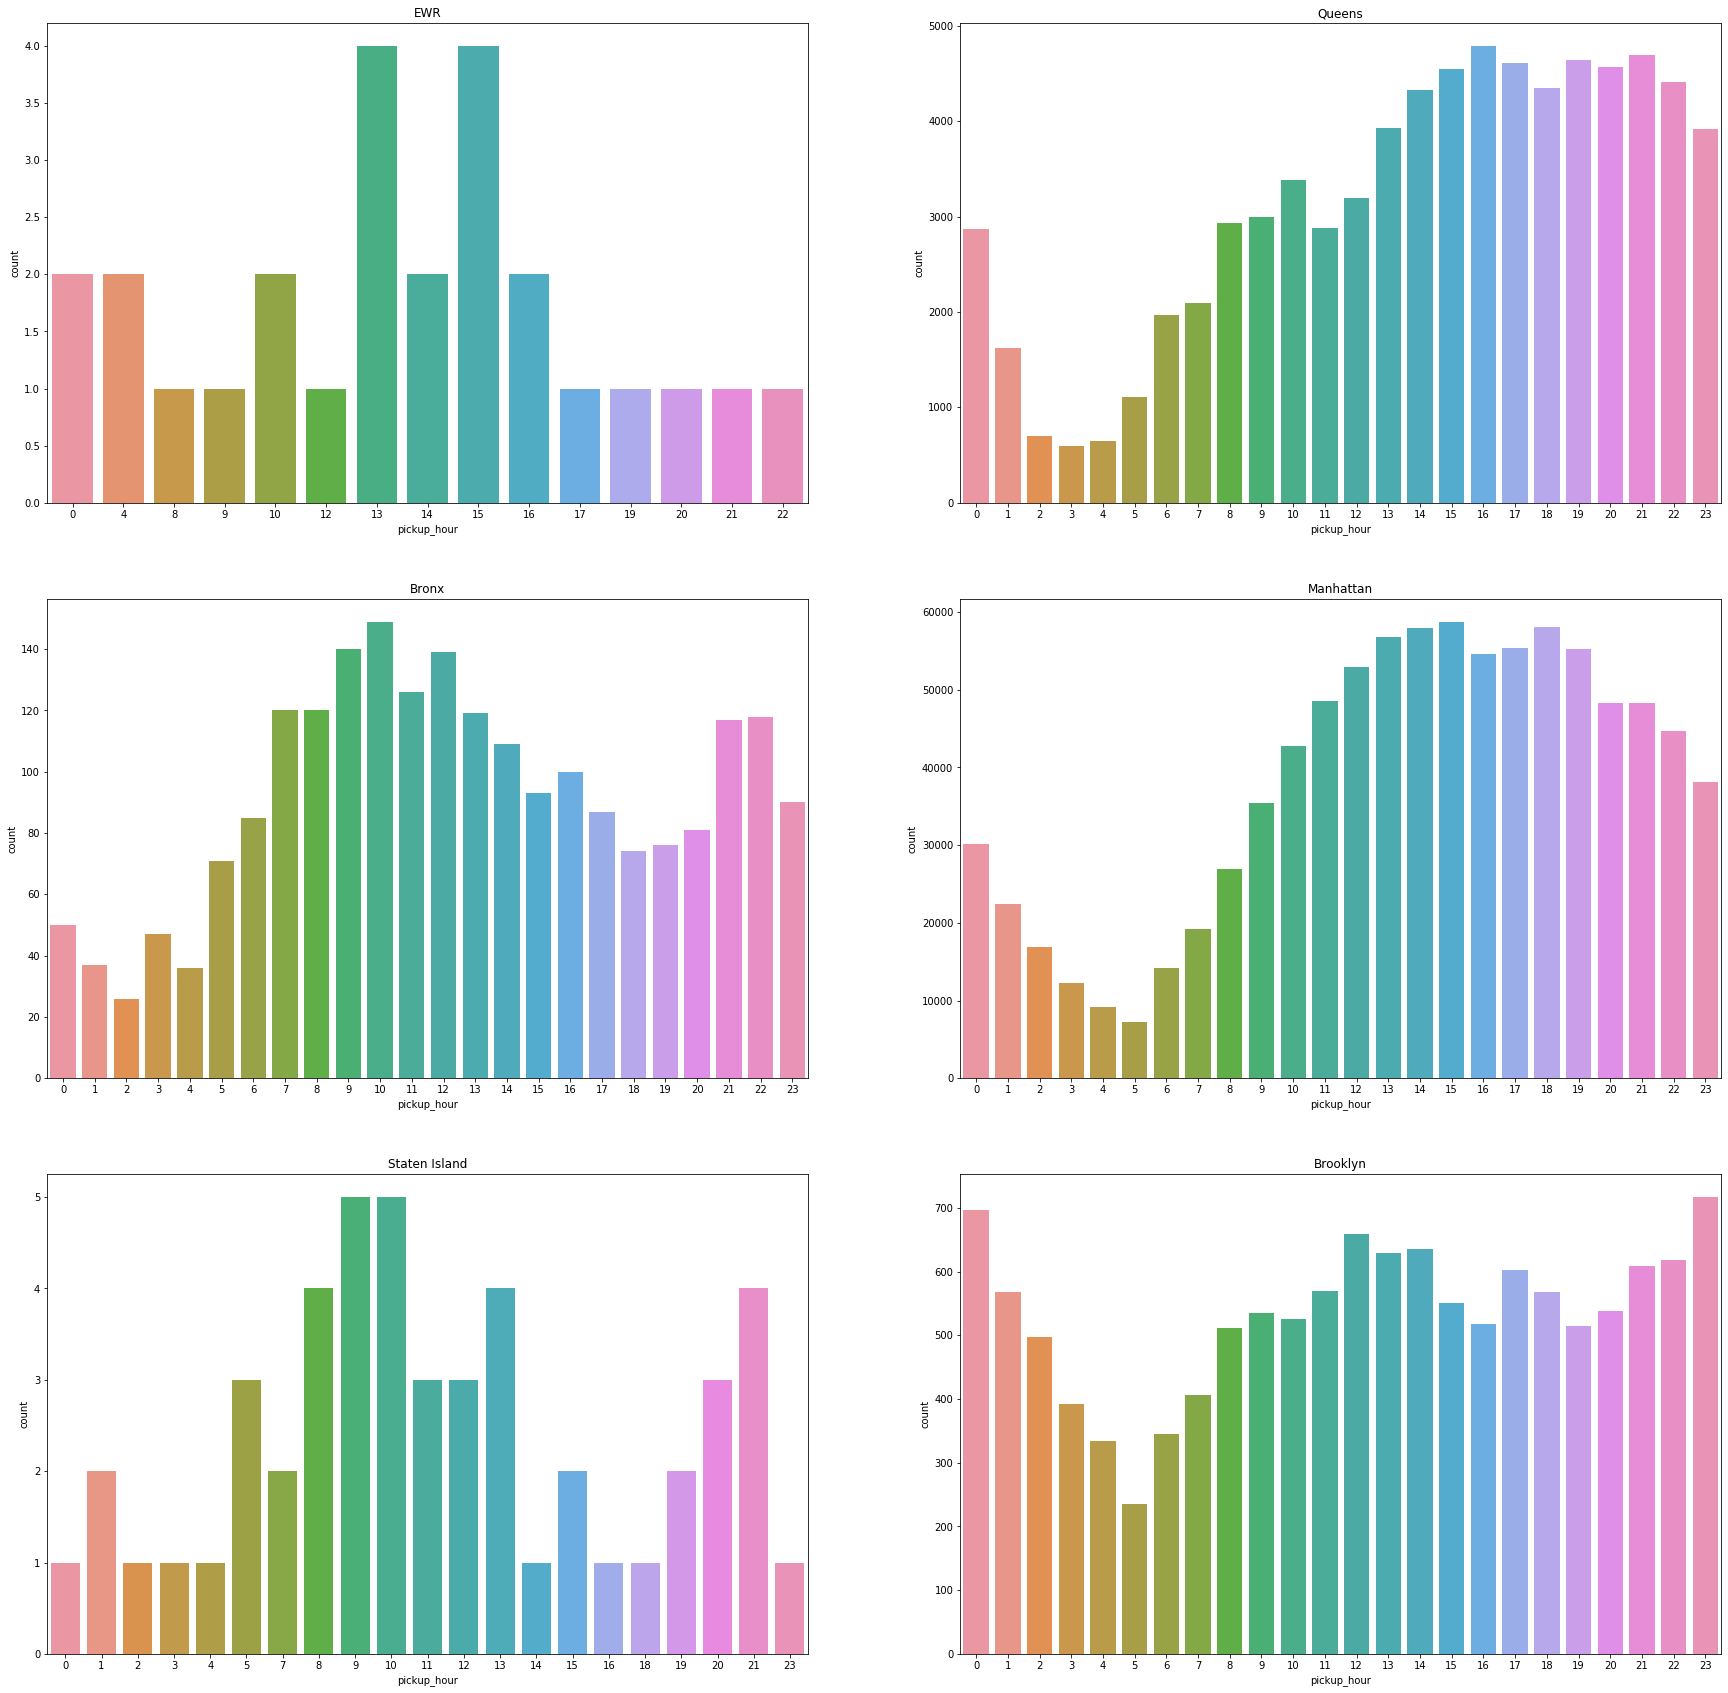

In [64]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_hour', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### What is the busiest day of a week in each borough of New York City?

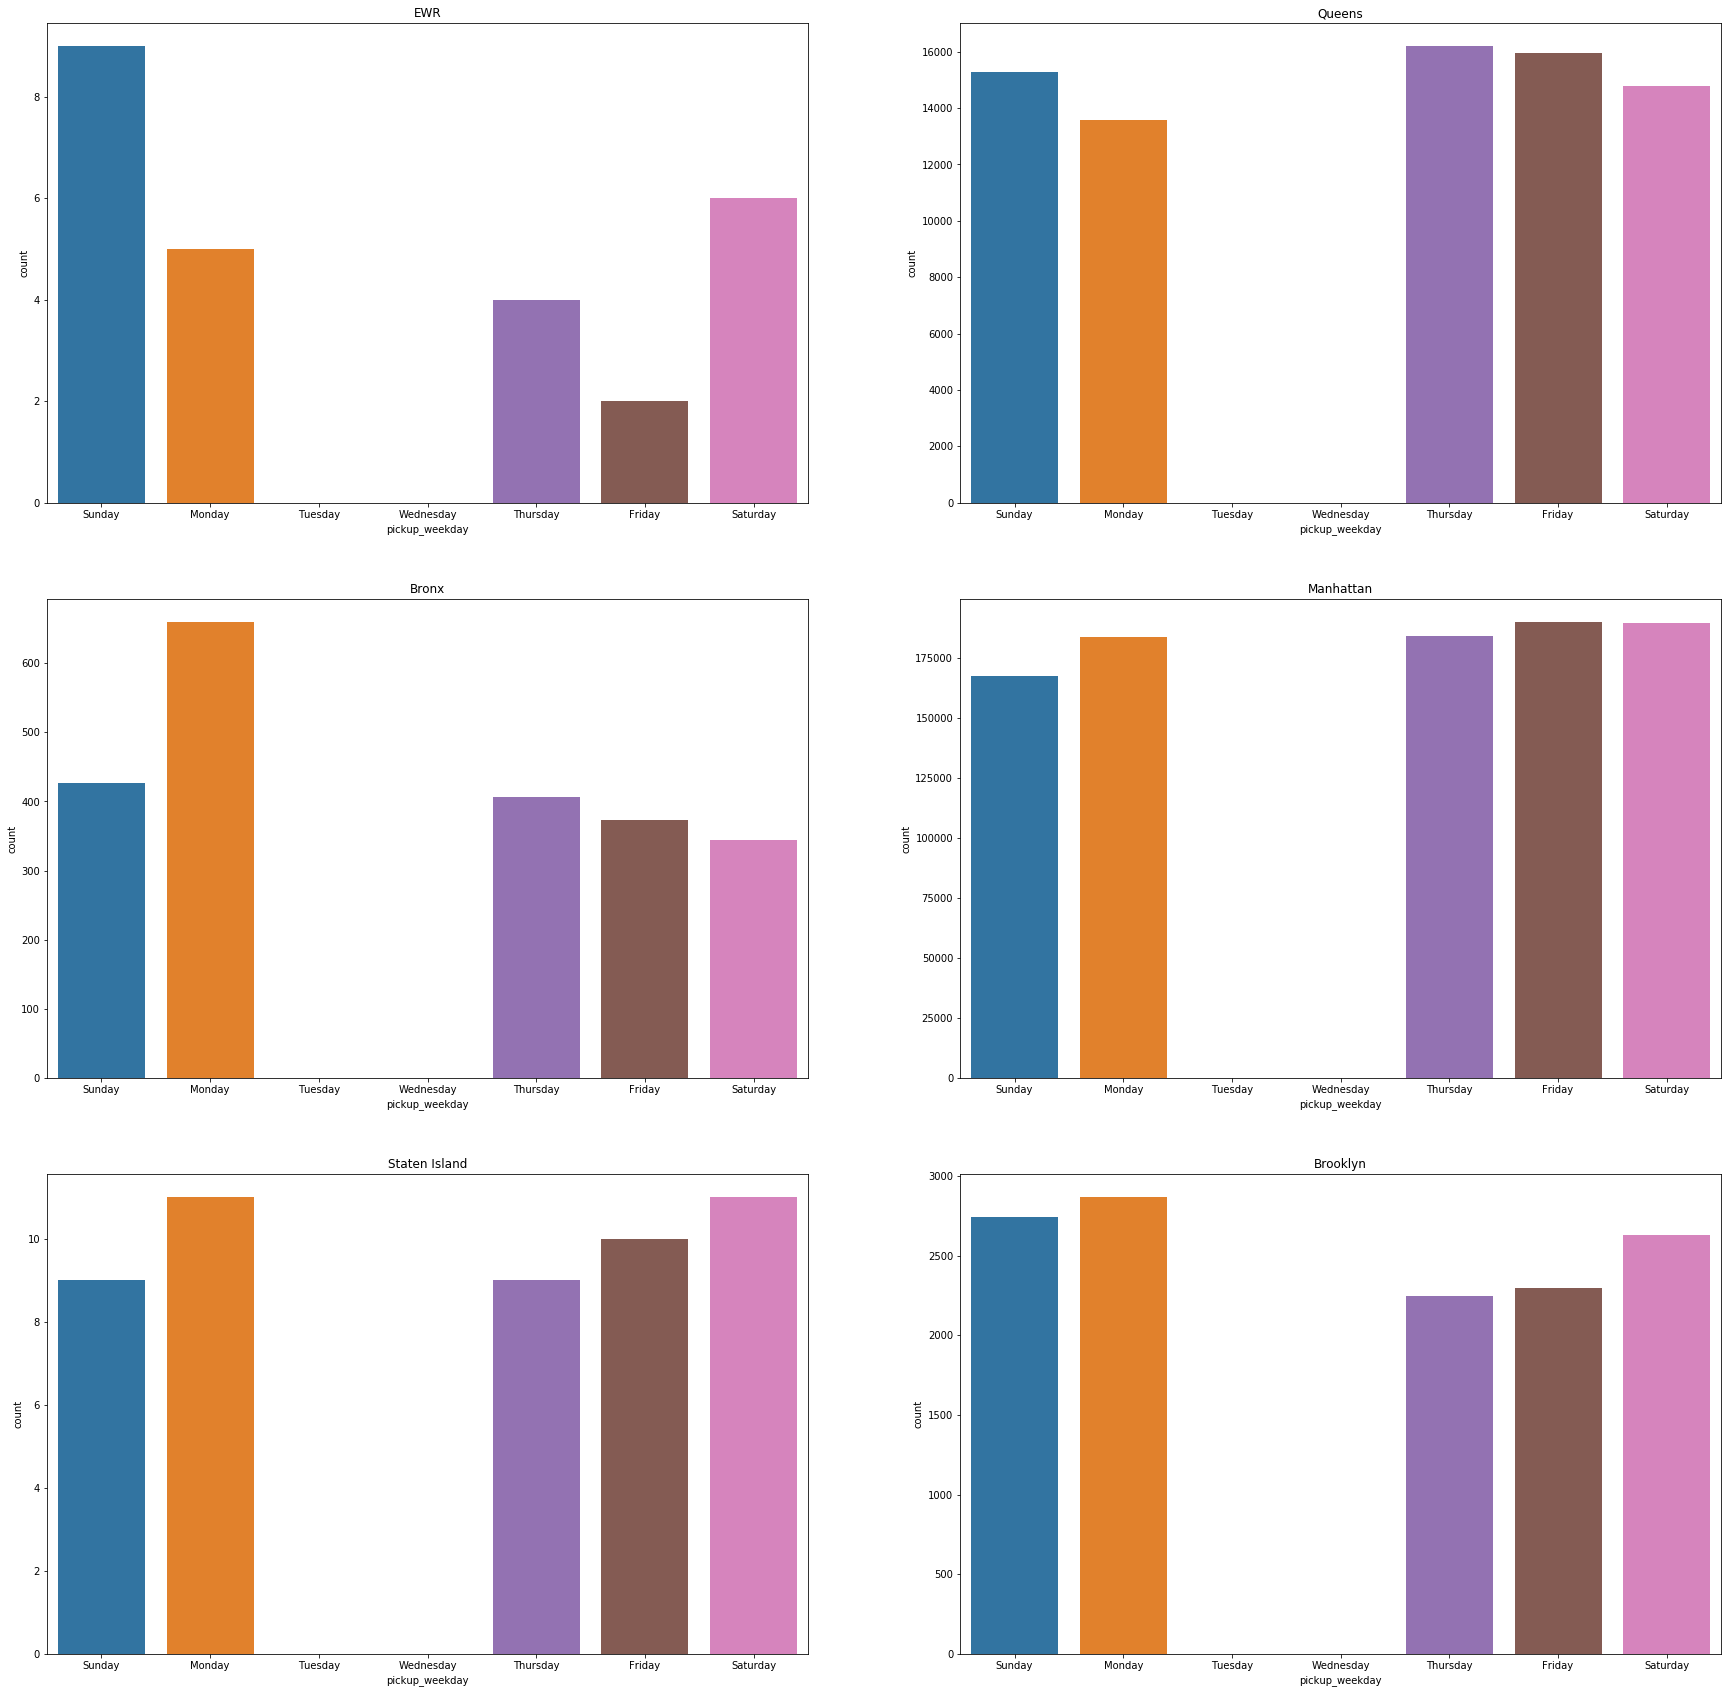

In [65]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_weekday', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Which day is busiest in december in each region?

#### Based on pickup location id

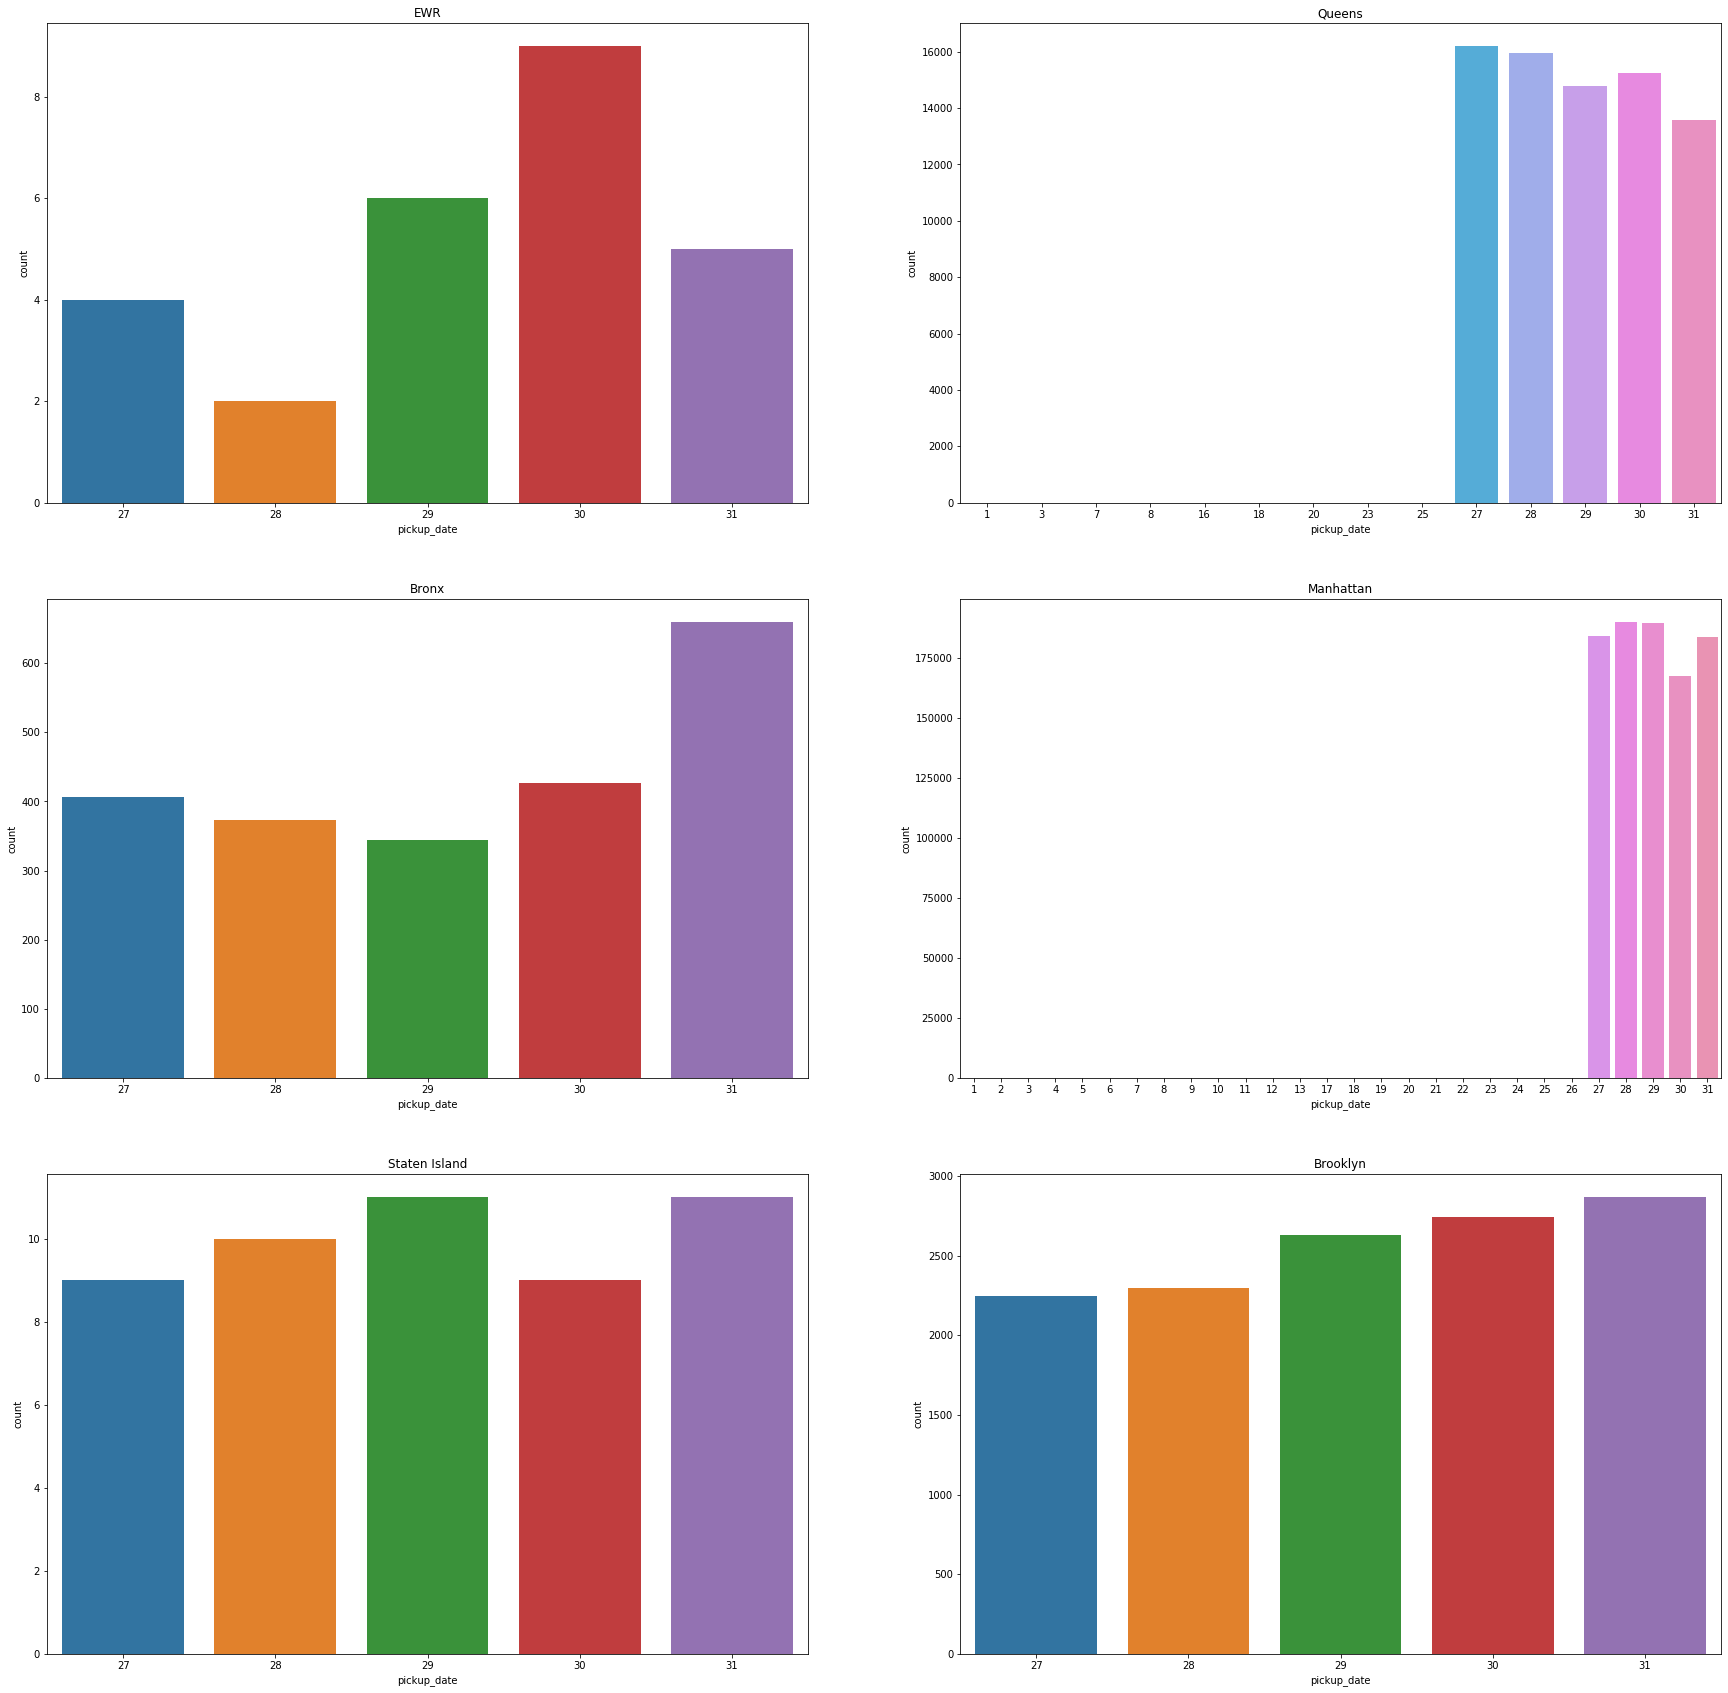

In [66]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

#### Based on dropoff location id

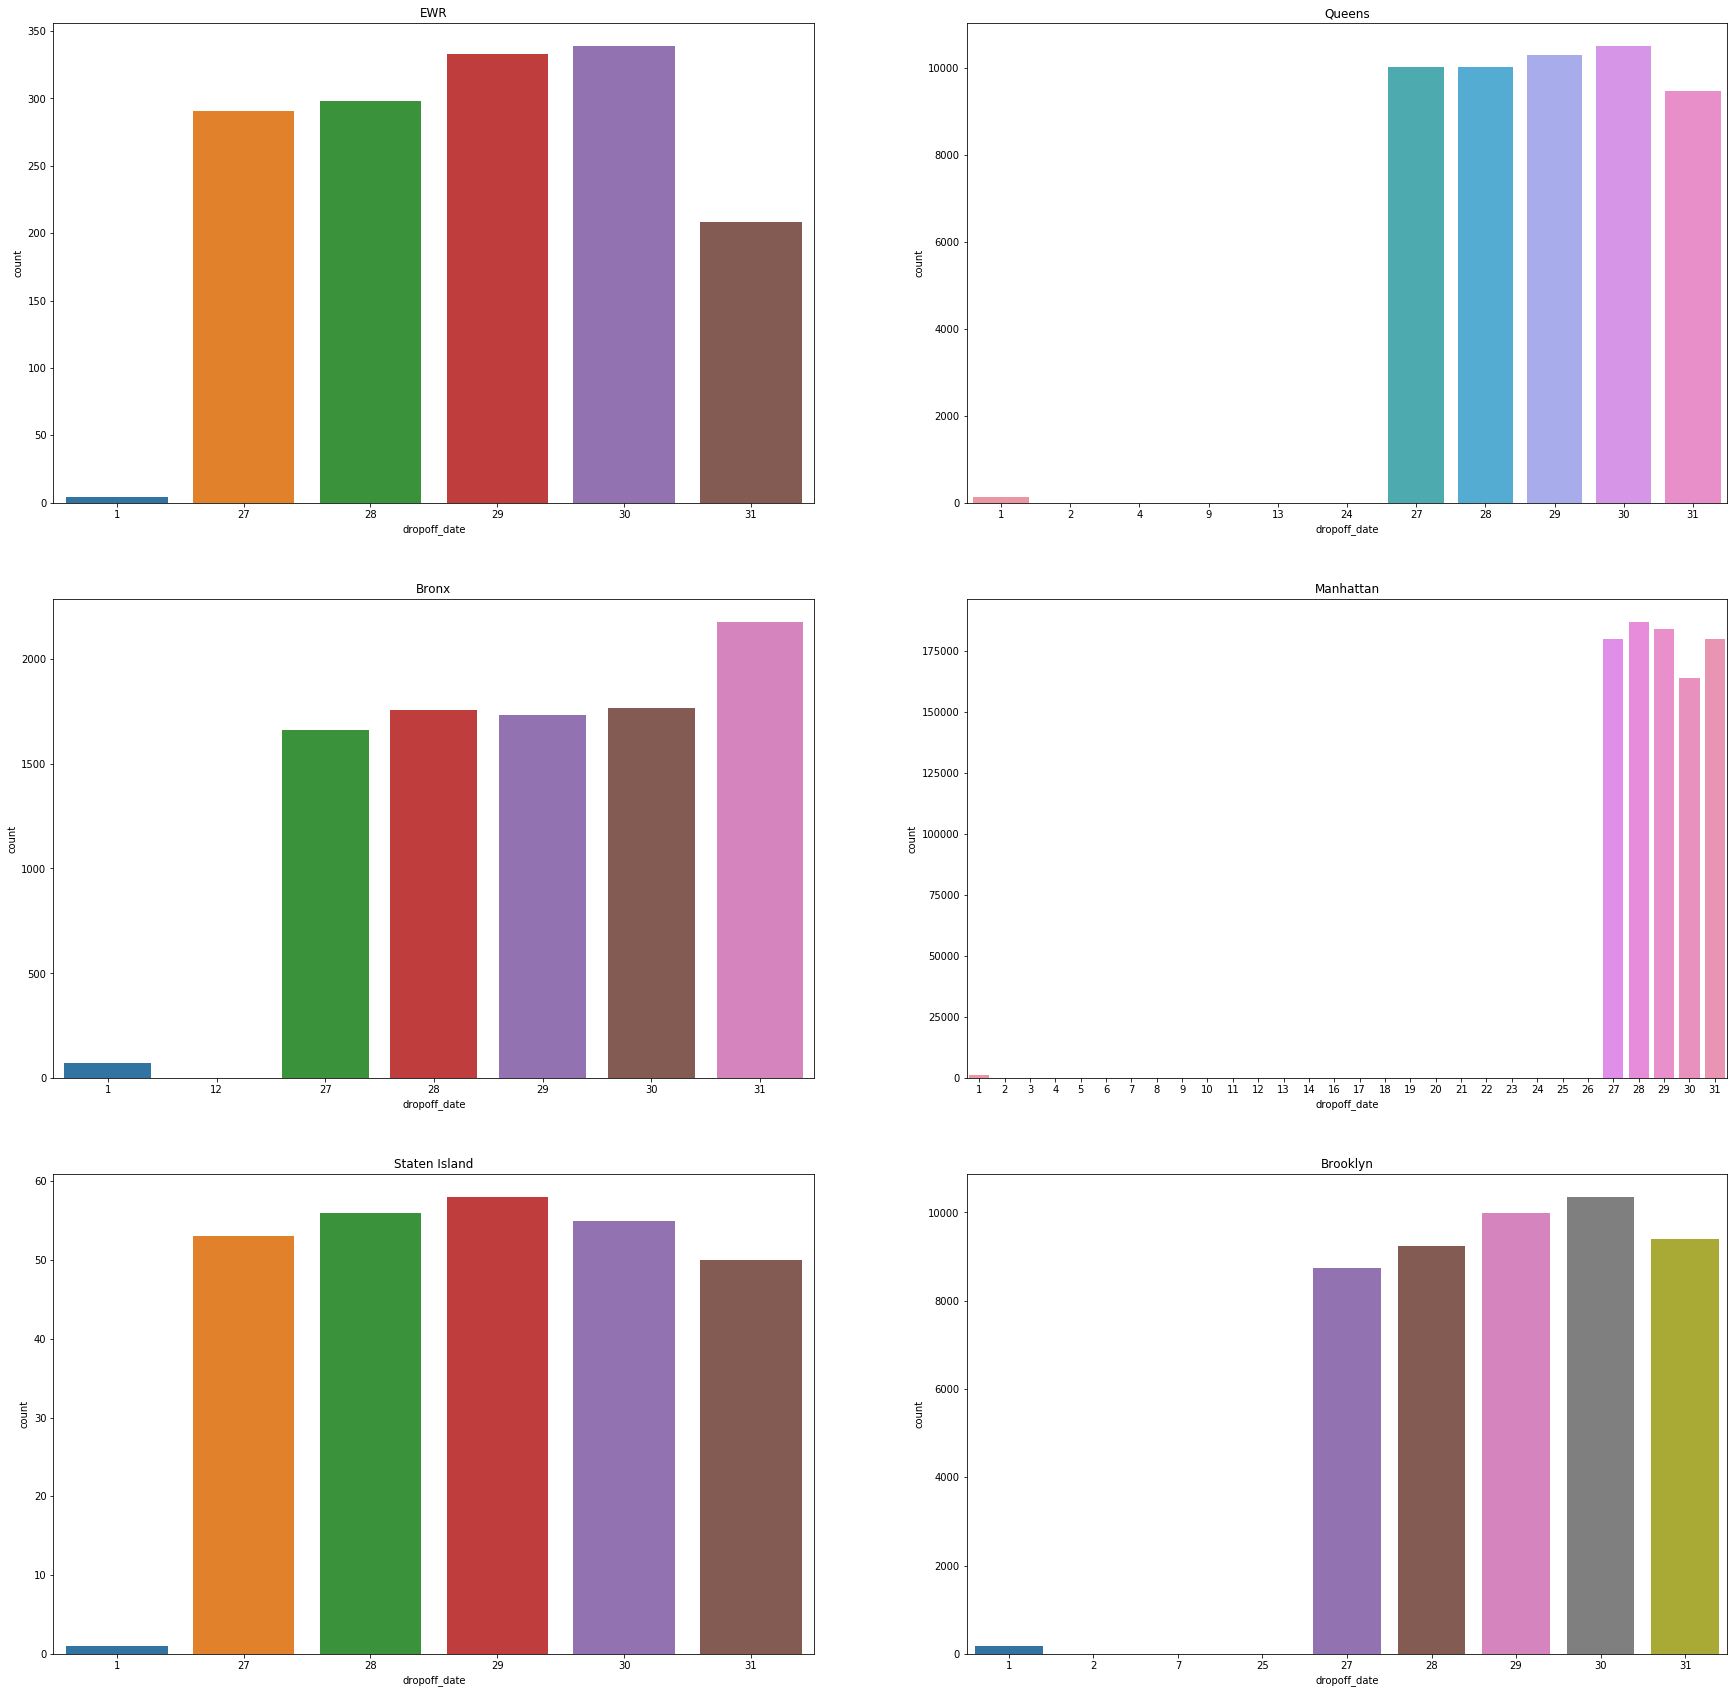

In [67]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'DOLocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='DOLocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='dropoff_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Show the number of trip vs day vs hour graph, so that we can easily know which time of a day is the busiest hour

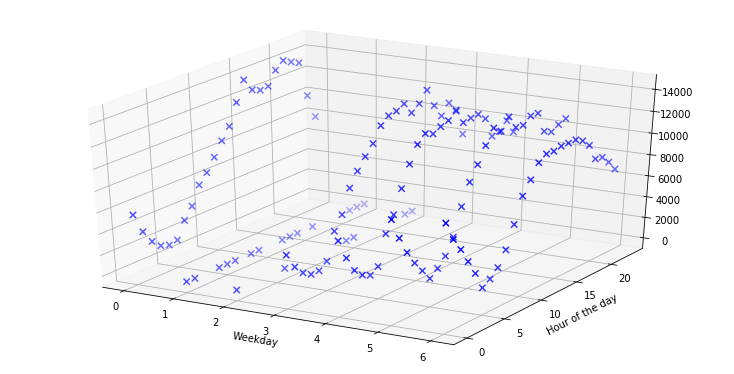

In [68]:
result = taxiSample.groupby(['pickup_dayofweek','pickup_hour'])['PULocationID'].count().reset_index(name='count')
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
x = result['pickup_dayofweek']
y = result['pickup_hour']
z = result['count']
ax.scatter(x, y, z, s=40, c='blue', marker='x')
plt.xlabel("Weekday")
plt.ylabel("Hour of the day")
plt.show()

## Trip duration

In [69]:
taxiSample['trip_duration'] = (taxiSample.tpep_dropoff_datetime - taxiSample.tpep_pickup_datetime).dt.total_seconds()

In [70]:
taxiSample.trip_duration.describe()

count    1.004842e+06
mean     1.111986e+03
std      4.972414e+03
min      1.000000e+00
25%      3.720000e+02
50%      6.420000e+02
75%      1.081000e+03
max      8.639400e+04
Name: trip_duration, dtype: float64

### Which day has the most trip duration?

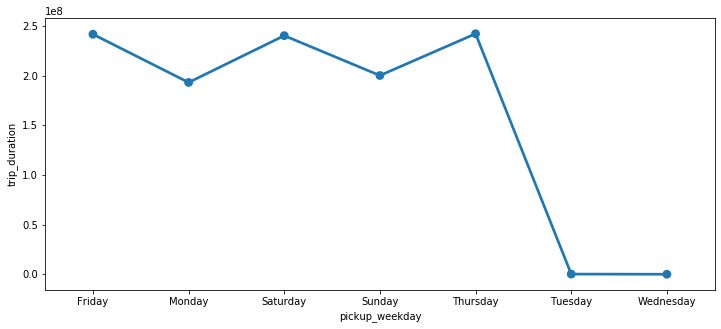

In [71]:
df_train_agg = taxiSample.groupby('pickup_weekday')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_weekday, df_train_agg.trip_duration)
plt.show()

### Which time has the most trip duration?

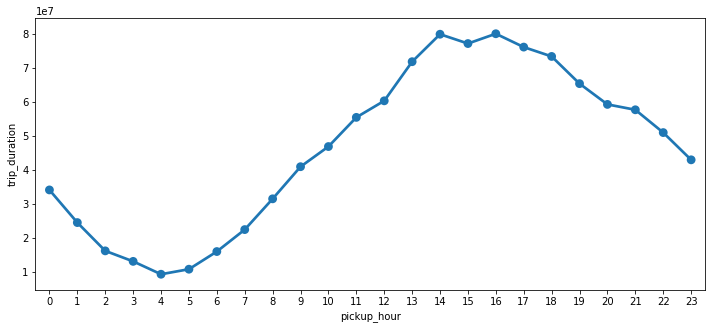

In [72]:
df_train_agg = taxiSample.groupby('pickup_hour')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_hour, df_train_agg.trip_duration)
plt.show()

## Trip distance

In [73]:
taxiSample['trip_distance'].describe()

count    1.004842e+06
mean     3.036813e+00
std      3.892059e+00
min      1.000000e-02
25%      9.700000e-01
50%      1.640000e+00
75%      3.120000e+00
max      9.117000e+01
Name: trip_distance, dtype: float64

### What is the number of short and long distance trip? (i.e. short distance<20)

In [74]:
short_distance = taxiSample[taxiSample.trip_distance<20.0]
long_distance = taxiSample[taxiSample.trip_distance>=20.0]
print(short_distance.shape)
print(long_distance.shape)

(997213, 29)
(7629, 29)


### Which time of the day has the most short distance trip?

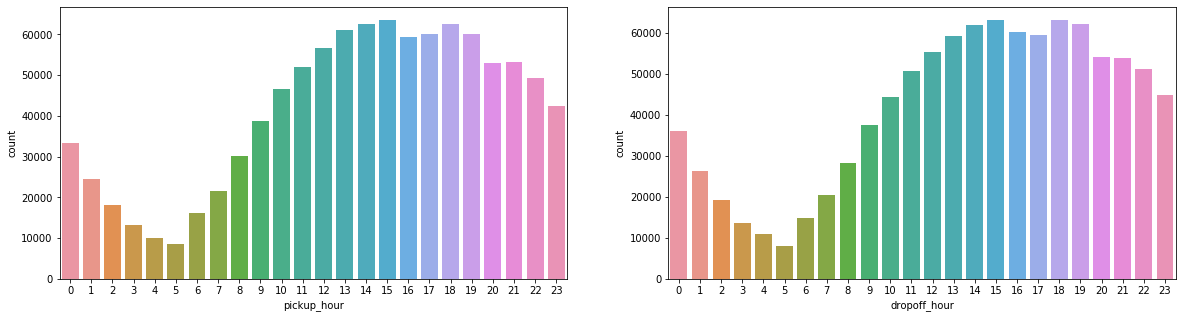

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=short_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=short_distance, ax=ax[1])
plt.show()

### Which time of the day has the most long distance trip?

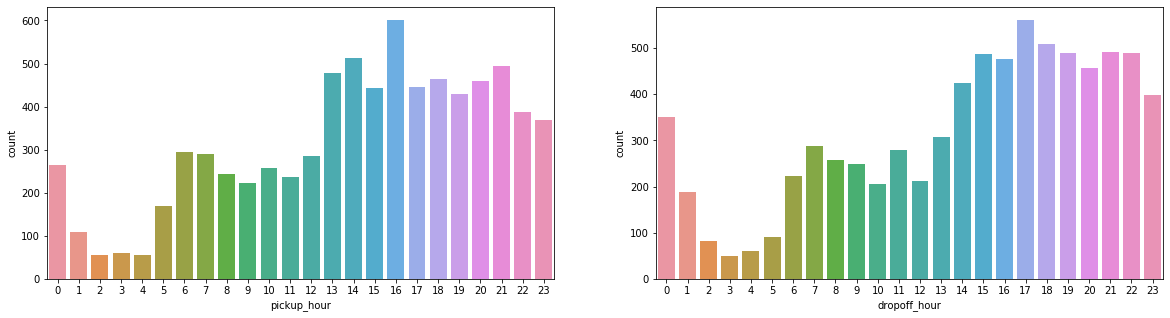

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=long_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=long_distance, ax=ax[1])
plt.show()

## Traffic condition

### What is the average trip distance of the day?

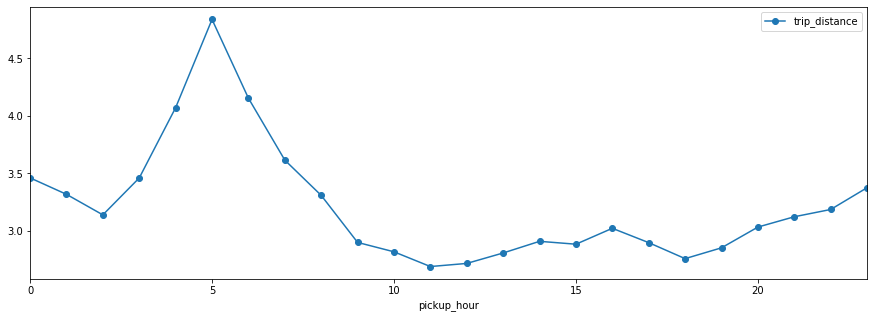

In [77]:
traffic = taxiSample.groupby('pickup_hour')['trip_distance','trip_duration'].mean().reset_index()
ax = traffic.plot(x='pickup_hour', y='trip_distance', kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the average trip duration of the day?

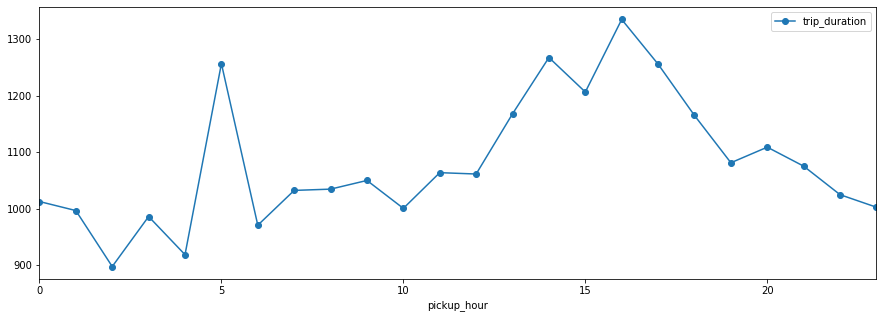

In [78]:
ax = traffic.plot(x='pickup_hour', y=['trip_duration'], kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the traffic condition(trip duration/trip distance) of different regions during a day?

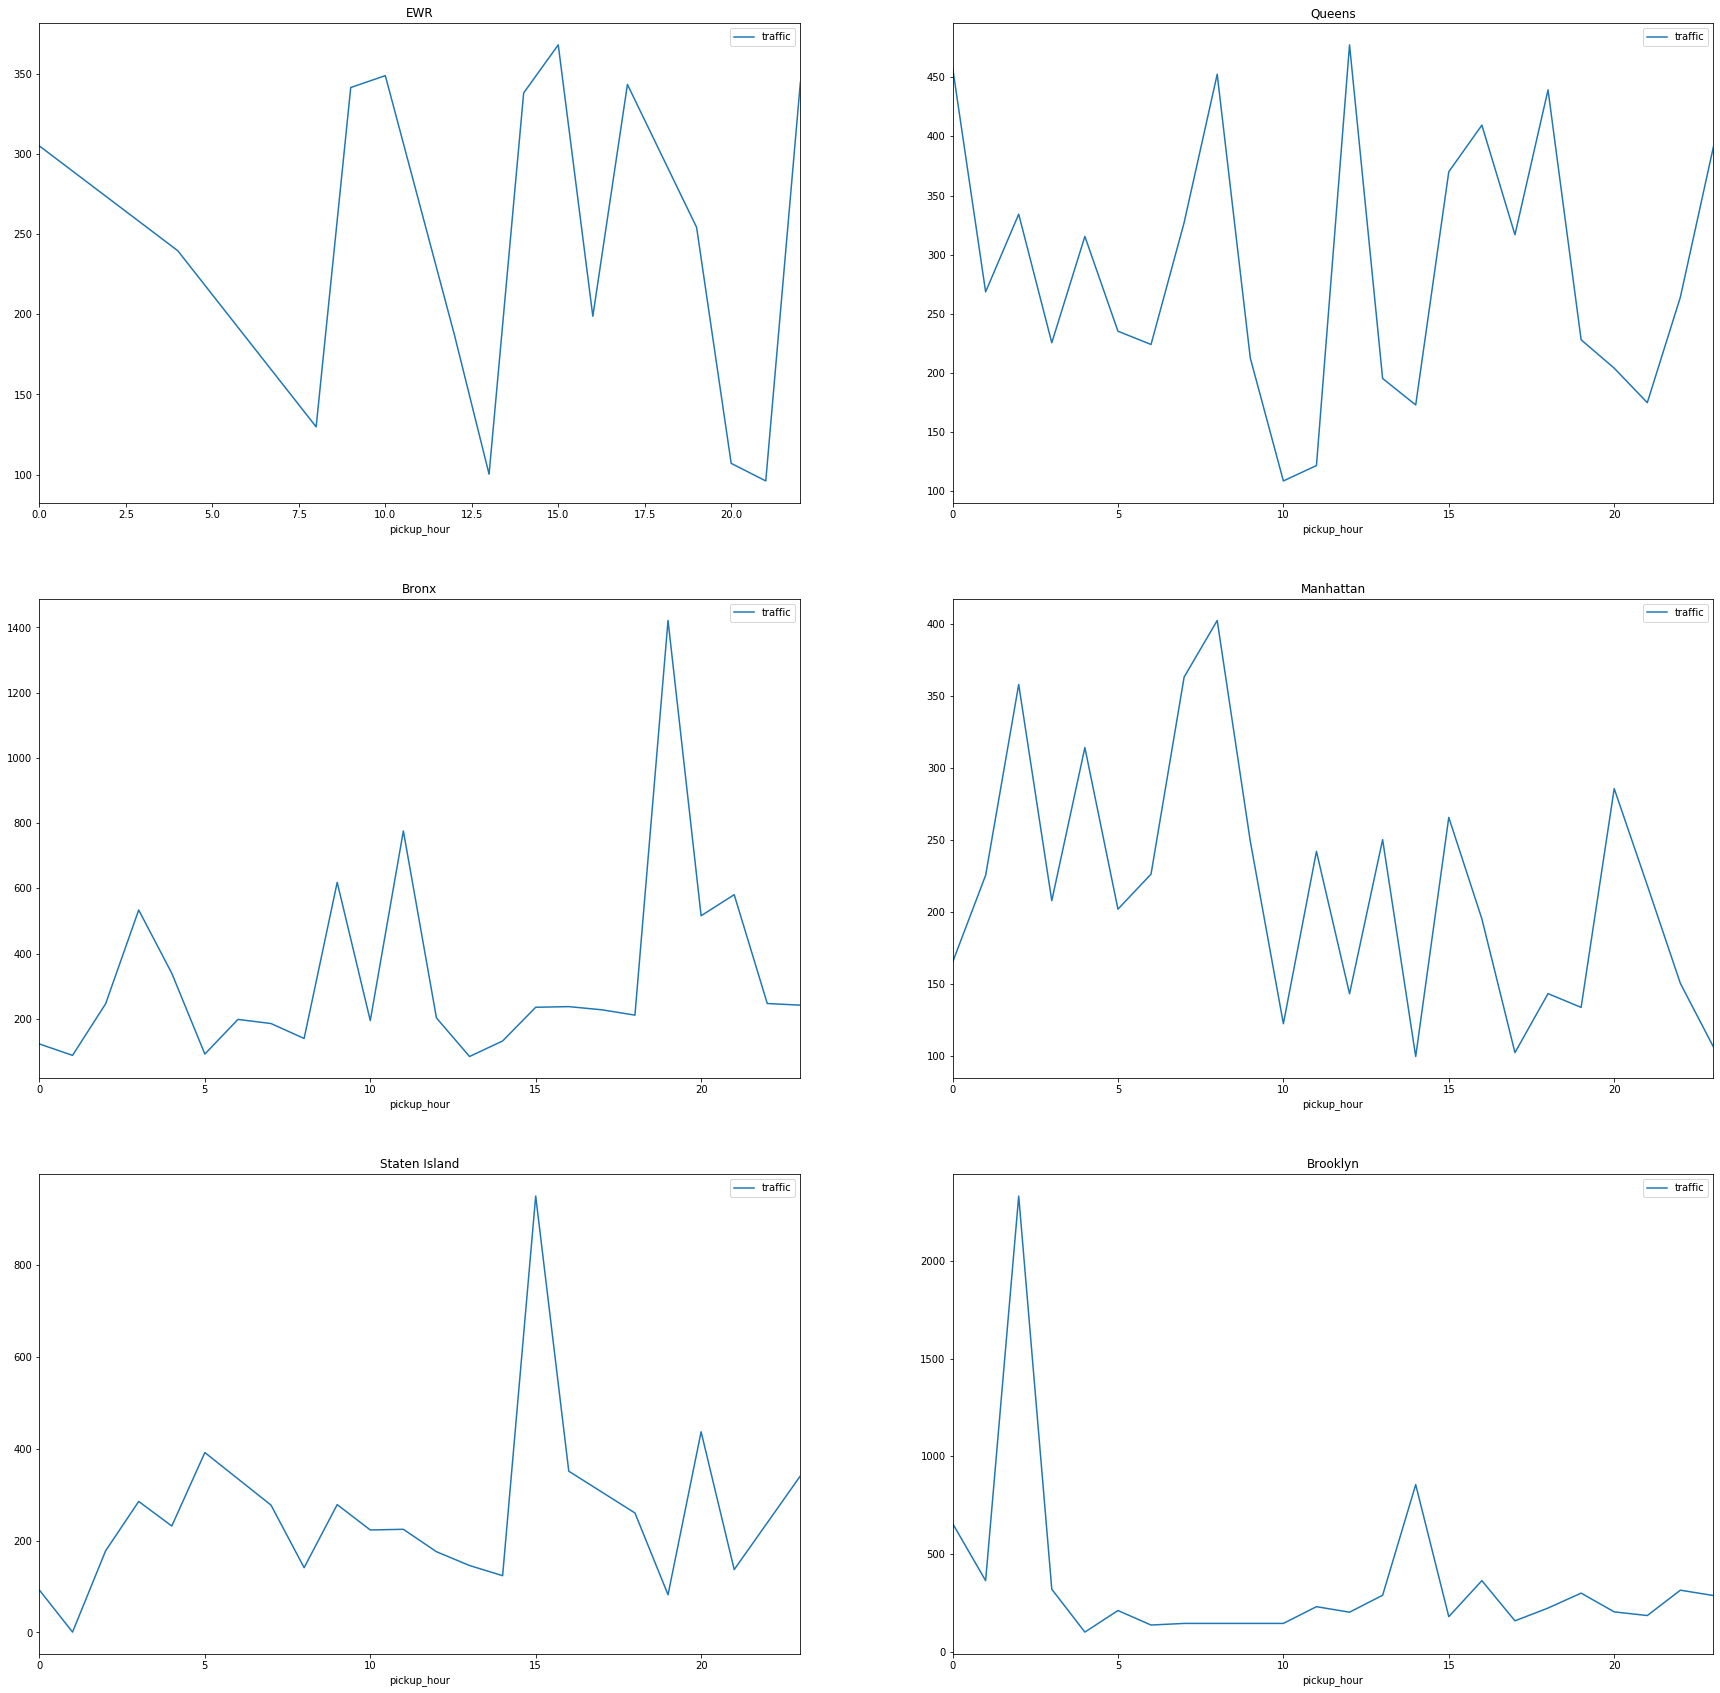

In [79]:
result = taxiSample.groupby(['pickup_hour','PULocationID'])['trip_distance','trip_duration'].sum().reset_index().rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','pickup_hour'])['trip_distance','trip_duration'].sum().reset_index()
groupResult['traffic'] = result['trip_duration']/result['trip_distance']
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    ax = fig.add_subplot(3, 2, index)
    boroughData = groupResult[groupResult.borough==borough]
    boroughData.plot(x='pickup_hour', y='traffic', ax=ax).set_title(borough)
    index += 1

## Pickup/Dropoff location id

In [80]:
pu_location = taxiSample.groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location = taxiSample.groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

### Show the top 5 zones with most pickups and dropoffs

In [81]:
pu_do_location = taxiZone.merge(pu_location, on='LocationID', how='left')
pu_do_location = pu_do_location.merge(do_location, on='LocationID', how='left')
pu_do_location['totalCount'] = pu_do_location['puCount'] + pu_do_location['doCount']
pu_do_location.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough     longitude       latitude  puCount  doCount  totalCount  
0            EWR  9.366817e+05  190522.130278     26.0   1473.0      1499.0  
1         Queens  1.033536e+06  161853.982300      1.0      1.0         2.0  
2          Bronx  1.027136e+06  254730.010849     27.0     89.0       116.0  
3      Manhattan  9.904240e+05  203100.040432   2221.0   5443.0      7664.0  
4  Staten Island  9.321332e+05  139954.541936      1.0      7.0         8.0

In [82]:
puCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['puCount'].tolist()))
puTop5 = pu_do_location.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['doCount'].tolist()))
doTop5 = pu_do_location.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 pickup zone

In [83]:
puTop5

OBJECTID  Shape_Leng  Shape_Area                          zone  \
LocationID                                                                   
186              186    0.024696    0.000037  Penn Station/Madison Sq West   
48                48    0.043747    0.000094                  Clinton East   
237              237    0.042213    0.000096         Upper East Side South   
161              161    0.035804    0.000072                Midtown Center   
162              162    0.035270    0.000048                  Midtown East   

              borough      longitude       latitude  puCount  doCount  \
LocationID                                                              
186         Manhattan  986346.343415  211974.157667  42281.0  27958.0   
48          Manhattan  987065.467994  216984.693458  38015.0  33968.0   
237         Manhattan  993768.783313  219305.448647  36698.0  32673.0   
161         Manhattan  990433.407940  215448.355221  36244.0  36966.0   
162         Manhattan  991876.747966  215015.150630  33173.0  28972.0   

            totalCount  
LocationID              
186            70239.0  
48             71983.0  
237            69371.0  
161            73210.0  
162            62145.0

#### Top 5 dropoff zone

In [84]:
doTop5

OBJECTID  Shape_Leng  Shape_Area                   zone  \
LocationID                                                            
161              161    0.035804    0.000072         Midtown Center   
48                48    0.043747    0.000094           Clinton East   
236              236    0.044252    0.000103  Upper East Side North   
237              237    0.042213    0.000096  Upper East Side South   
170              170    0.045769    0.000074            Murray Hill   

              borough      longitude       latitude  puCount  doCount  \
LocationID                                                              
161         Manhattan  990433.407940  215448.355221  36244.0  36966.0   
48          Manhattan  987065.467994  216984.693458  38015.0  33968.0   
236         Manhattan  996155.897922  223614.973989  32533.0  33856.0   
237         Manhattan  993768.783313  219305.448647  36698.0  32673.0   
170         Manhattan  990443.335463  211693.748324  30165.0  30042.0   

            totalCount  
LocationID              
161            73210.0  
48             71983.0  
236            66389.0  
237            69371.0  
170            60207.0

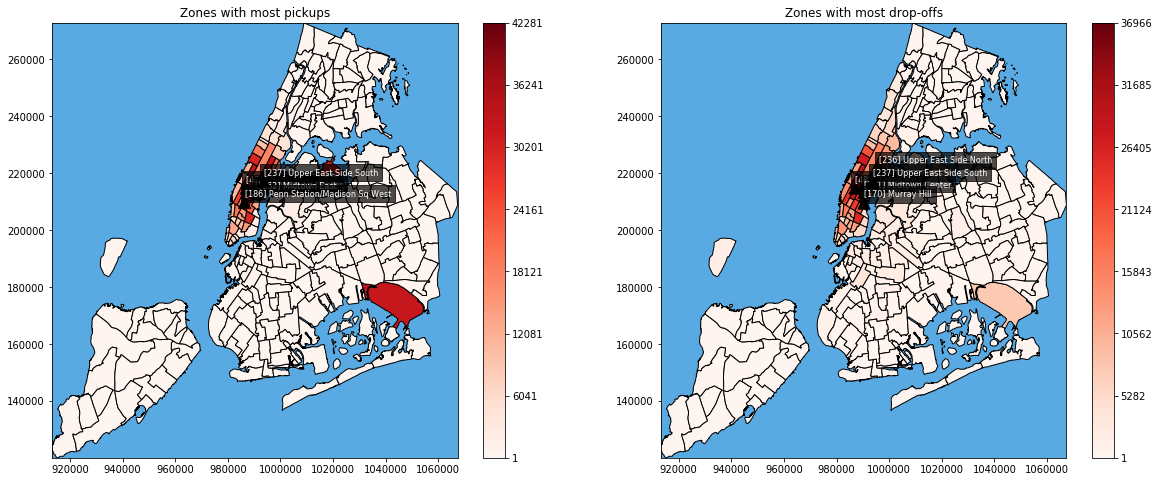

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, taxiZonesShape, heat=puCount, text=puTop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, taxiZonesShape, heat=doCount, text=doTop5.index.tolist())

### Which region has the most pickups and dropoffs?

In [86]:
pu_do_region = pu_do_location.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region

borough   puCount   doCount  totalCount
3      Manhattan  914271.0  896686.0   1810957.0
4         Queens   75771.0   50454.0    126207.0
1       Brooklyn   12779.0   47898.0     60677.0
0          Bronx    2210.0    9159.0     11342.0
2            EWR      26.0    1473.0      1499.0
5  Staten Island      50.0     273.0       287.0

In [87]:
puCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['puCount'].tolist()))
doCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['doCount'].tolist()))

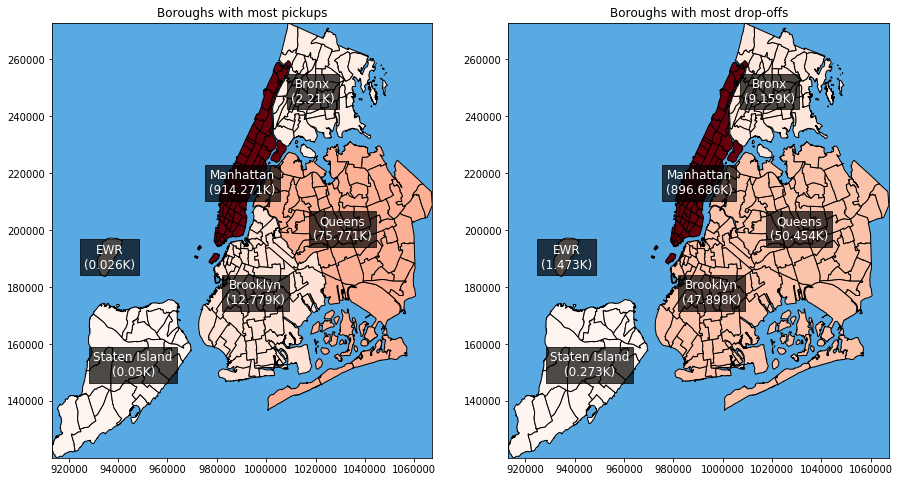

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, taxiZonesShape, heat = puCount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, taxiZonesShape, heat = doCount)

### Which zone has the most pickups/dropoffs for short trips (distance<20) and long trips (distance>=20)

In [89]:
pu_location_short = taxiSample[taxiSample.trip_distance<20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_short = taxiSample[taxiSample.trip_distance<20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_short = taxiZone.merge(pu_location_short, on='LocationID', how='left')
pu_do_location_short = pu_do_location_short.merge(do_location_short, on='LocationID', how='left')
pu_do_location_short['totalCount'] = pu_do_location_short['puCount'] + pu_do_location_short['doCount']

In [90]:
pu_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_long = taxiZone.merge(pu_location_long, on='LocationID', how='left')
pu_do_location_long = pu_do_location_long.merge(do_location_long, on='LocationID', how='left')
pu_do_location_long['totalCount'] = pu_do_location_long['puCount'] + pu_do_location_long['doCount']

In [91]:
puCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['puCount'].tolist()))
puTop5Short = pu_do_location_short.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['doCount'].tolist()))
doTop5Short = pu_do_location_short.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 short distance pickup zone

In [92]:
puTop5Short

OBJECTID  Shape_Leng  Shape_Area                          zone  \
LocationID                                                                   
186              186    0.024696    0.000037  Penn Station/Madison Sq West   
48                48    0.043747    0.000094                  Clinton East   
237              237    0.042213    0.000096         Upper East Side South   
161              161    0.035804    0.000072                Midtown Center   
162              162    0.035270    0.000048                  Midtown East   

              borough      longitude       latitude  puCount  doCount  \
LocationID                                                              
186         Manhattan  986346.343415  211974.157667  42254.0  27944.0   
48          Manhattan  987065.467994  216984.693458  37927.0  33878.0   
237         Manhattan  993768.783313  219305.448647  36663.0  32582.0   
161         Manhattan  990433.407940  215448.355221  36191.0  36926.0   
162         Manhattan  991876.747966  215015.150630  33138.0  28920.0   

            totalCount  
LocationID              
186            70198.0  
48             71805.0  
237            69245.0  
161            73117.0  
162            62058.0

#### Top 5 short distance dropoff zone

In [93]:
doTop5Short

OBJECTID  Shape_Leng  Shape_Area                   zone  \
LocationID                                                            
161              161    0.035804    0.000072         Midtown Center   
48                48    0.043747    0.000094           Clinton East   
236              236    0.044252    0.000103  Upper East Side North   
237              237    0.042213    0.000096  Upper East Side South   
170              170    0.045769    0.000074            Murray Hill   

              borough      longitude       latitude  puCount  doCount  \
LocationID                                                              
161         Manhattan  990433.407940  215448.355221  36191.0  36926.0   
48          Manhattan  987065.467994  216984.693458  37927.0  33878.0   
236         Manhattan  996155.897922  223614.973989  32494.0  33810.0   
237         Manhattan  993768.783313  219305.448647  36663.0  32582.0   
170         Manhattan  990443.335463  211693.748324  30142.0  30033.0   

            totalCount  
LocationID              
161            73117.0  
48             71805.0  
236            66304.0  
237            69245.0  
170            60175.0

In [94]:
puCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['puCount'].tolist()))
puTop5Long = pu_do_location_long.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['doCount'].tolist()))
doTop5Long = pu_do_location_long.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 long distance pickup zone

In [95]:
puTop5Long

OBJECTID  Shape_Leng  Shape_Area                   zone  \
LocationID                                                            
132              132    0.245479    0.002038            JFK Airport   
239              239    0.063626    0.000205  Upper West Side South   
142              142    0.038176    0.000076    Lincoln Square East   
138              138    0.107467    0.000537      LaGuardia Airport   
13                13    0.050281    0.000149      Battery Park City   

              borough     longitude       latitude  puCount  doCount  \
LocationID                                                             
132            Queens  1.042628e+06  173494.353508   5440.0    877.0   
239         Manhattan  9.901399e+05  224918.916683    140.0    393.0   
142         Manhattan  9.893656e+05  221142.058374    104.0    253.0   
138            Queens  1.019304e+06  221604.395797     98.0     17.0   
13          Manhattan  9.798442e+05  198508.159318     90.0    203.0   

            totalCount  
LocationID              
132             6317.0  
239              533.0  
142              357.0  
138              115.0  
13               293.0

#### Top 5 long distance dropoff zone

In [96]:
doTop5Long

OBJECTID  Shape_Leng  Shape_Area                      zone  \
LocationID                                                               
132              132    0.245479    0.002038               JFK Airport   
239              239    0.063626    0.000205     Upper West Side South   
238              238    0.060109    0.000185     Upper West Side North   
1                  1    0.116357    0.000782            Newark Airport   
87                87    0.036902    0.000067  Financial District North   

              borough     longitude       latitude  puCount  doCount  \
LocationID                                                             
132            Queens  1.042628e+06  173494.353508   5440.0    877.0   
239         Manhattan  9.901399e+05  224918.916683    140.0    393.0   
238         Manhattan  9.917176e+05  227746.100420     67.0    360.0   
1                 EWR  9.366817e+05  190522.130278      2.0    282.0   
87          Manhattan  9.822430e+05  196731.423073     48.0    273.0   

            totalCount  
LocationID              
132             6317.0  
239              533.0  
238              427.0  
1                284.0  
87               321.0

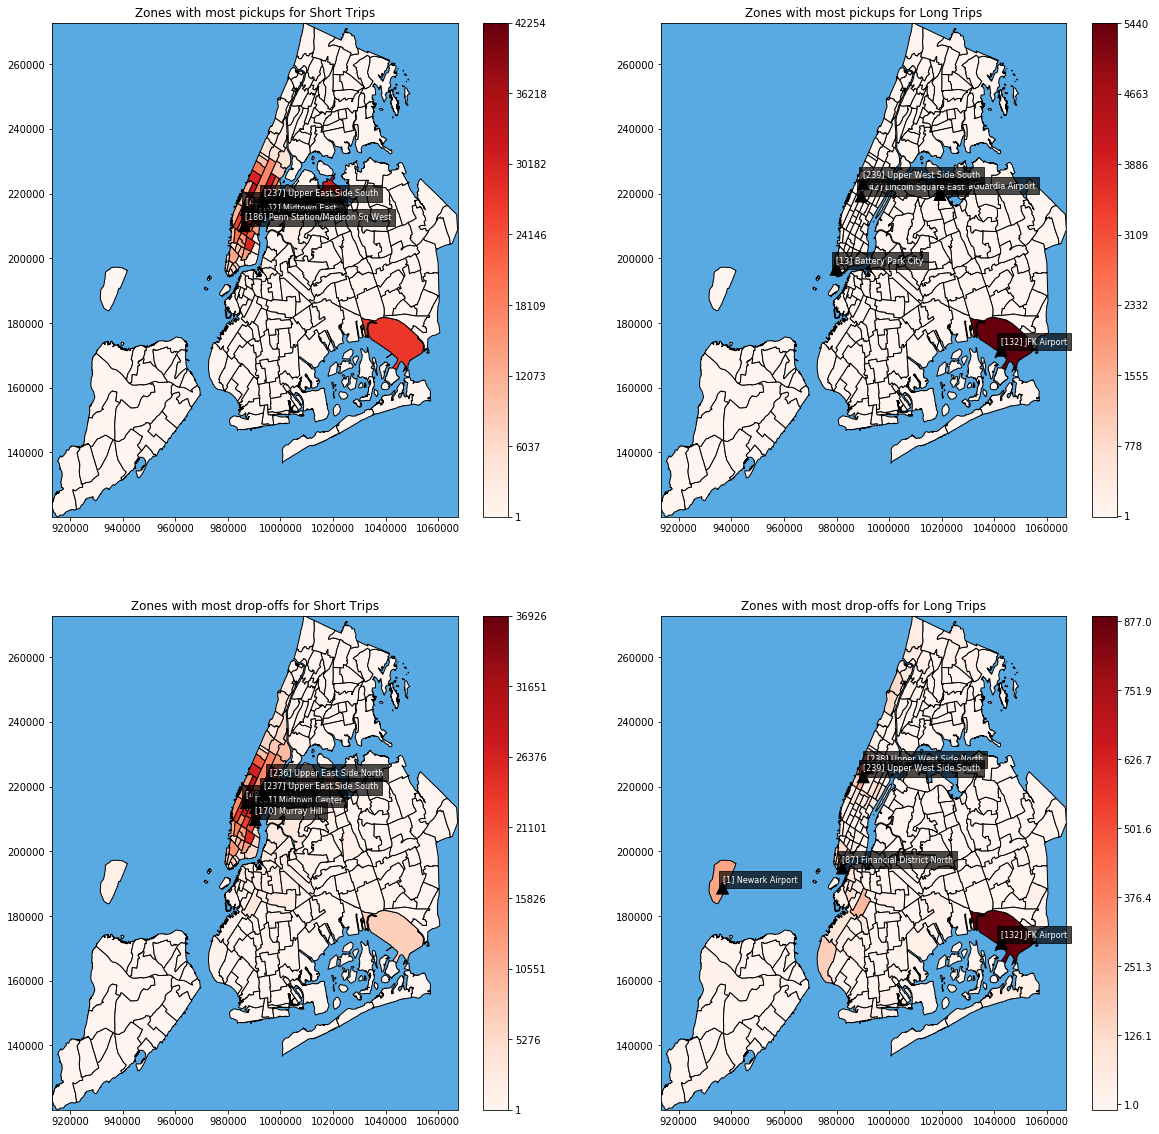

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountShort, text=puTop5Short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountLong, text=puTop5Long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountShort, text=doTop5Short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountLong, text=doTop5Long.index.tolist())

### Which region is popular for short trips and long trips?

#### Most popular region for short trips

In [98]:
pu_do_region_short = pu_do_location_short.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_short

borough   puCount   doCount  totalCount
3      Manhattan  912637.0  892692.0   1805329.0
4         Queens   70079.0   49246.0    119308.0
1       Brooklyn   12581.0   46382.0     58963.0
0          Bronx    2119.0    8674.0     10745.0
2            EWR      24.0    1191.0      1215.0
5  Staten Island      38.0     126.0       139.0

#### Most popular region for long trips

In [99]:
pu_do_region_long = pu_do_location_long.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_long

borough  puCount  doCount  totalCount
4         Queens   5692.0   1208.0      6868.0
3      Manhattan   1634.0   3994.0      5621.0
1       Brooklyn    198.0   1516.0      1594.0
0          Bronx     91.0    485.0       462.0
2            EWR      2.0    282.0       284.0
5  Staten Island     12.0    147.0        78.0

In [100]:
totalCountShort = dict(zip(pu_do_region_short['borough'].tolist(), pu_do_region_short['totalCount'].tolist()))
totalCountLong = dict(zip(pu_do_region_long['borough'].tolist(), pu_do_region_long['totalCount'].tolist()))

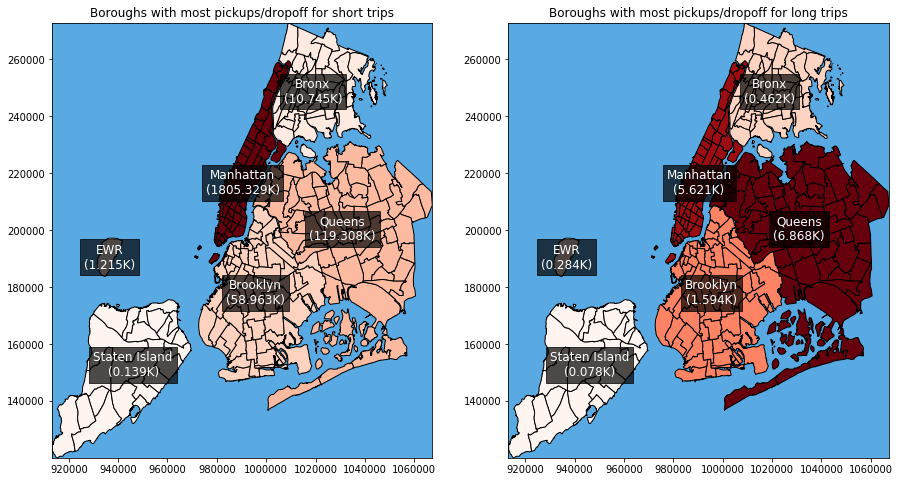

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups/dropoff for short trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountShort)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most pickups/dropoff for long trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountLong)

### Show top 5 inter zone trip

In [102]:
intraZone = taxiSample[taxiSample.PULocationID == taxiSample.DOLocationID].groupby('PULocationID')['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'}).sort_values(by='count', ascending=False).head(5)
intraZone = intraZone.merge(taxiZone, on='LocationID', how='left')
intraZone

LocationID  count  OBJECTID  Shape_Leng  Shape_Area                   zone  \
0         237   4097       237    0.042213    0.000096  Upper East Side South   
1         236   4036       236    0.044252    0.000103  Upper East Side North   
2          48   2919        48    0.043747    0.000094           Clinton East   
3         239   2569       239    0.063626    0.000205  Upper West Side South   
4          79   2346        79    0.042625    0.000108           East Village   

     borough      longitude       latitude  
0  Manhattan  993768.783313  219305.448647  
1  Manhattan  996155.897922  223614.973989  
2  Manhattan  987065.467994  216984.693458  
3  Manhattan  990139.871381  224918.916683  
4  Manhattan  988320.124716  204490.058251

In [103]:
countList = dict(zip(intraZone['LocationID'].tolist(), intraZone['count'].tolist()))

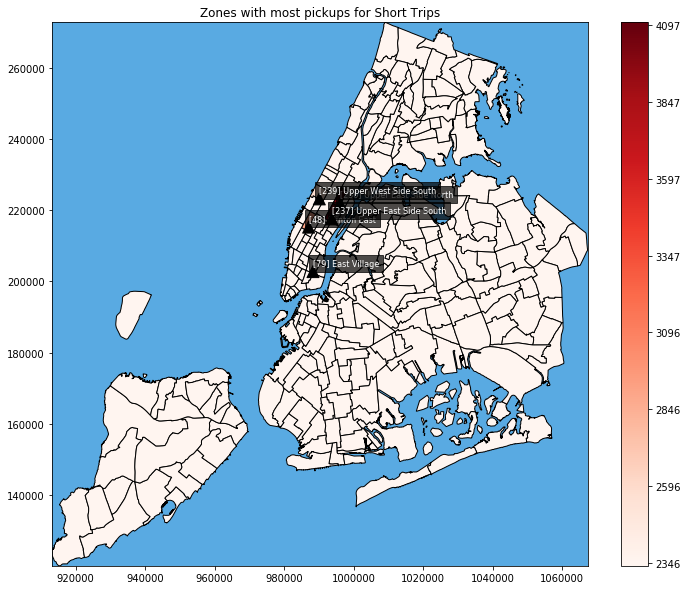

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
ax = plt.subplot(1, 1, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=countList, text=intraZone.LocationID.tolist())

### Show top 5 short distance trip

In [105]:
top5Short = taxiSample[taxiSample.trip_distance<20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Short.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Short['Pick-Up-Zone']=puZones
top5Short['Pick-Up-Borough']=puBoroughs
top5Short['Drop-Off-Zone']=doZones
top5Short['Drop-Off-Borough']=doBoroughs
top5Short

PULocationID  DOLocationID  count           Pick-Up-Zone  \
15729           237           236   4521  Upper East Side South   
15730           237           237   4097  Upper East Side South   
15543           236           236   4035  Upper East Side North   
15544           236           237   3867  Upper East Side North   
16004           239           142   3501  Upper West Side South   

      Pick-Up-Borough          Drop-Off-Zone Drop-Off-Borough  
15729       Manhattan  Upper East Side North        Manhattan  
15730       Manhattan  Upper East Side South        Manhattan  
15543       Manhattan  Upper East Side North        Manhattan  
15544       Manhattan  Upper East Side South        Manhattan  
16004       Manhattan    Lincoln Square East        Manhattan

### Show top 5 long distance trip

In [106]:
top5Long = taxiSample[taxiSample.trip_distance>=20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Long.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Long['Pick-Up-Zone']=puZones
top5Long['Pick-Up-Borough']=puBoroughs
top5Long['Drop-Off-Zone']=doZones
top5Long['Drop-Off-Borough']=doBoroughs
top5Long

PULocationID  DOLocationID  count Pick-Up-Zone Pick-Up-Borough  \
567           132           239    389  JFK Airport          Queens   
566           132           238    355  JFK Airport          Queens   
464           132            87    271  JFK Airport          Queens   
497           132           142    249  JFK Airport          Queens   
526           132           181    226  JFK Airport          Queens   

                Drop-Off-Zone Drop-Off-Borough  
567     Upper West Side South        Manhattan  
566     Upper West Side North        Manhattan  
464  Financial District North        Manhattan  
497       Lincoln Square East        Manhattan  
526                Park Slope         Brooklyn

### Which region is the most expensive? (totalCost/totalDistance)

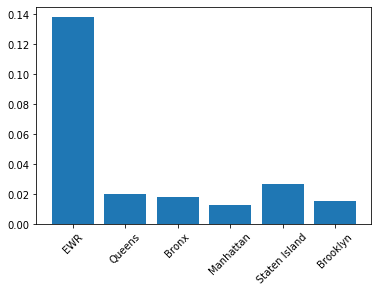

In [107]:
expenseRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    expenseRatio[borough]=totalRideBorough['total_amount'].sum()/totalRideBorough['trip_duration'].sum()
    
plt.bar(range(len(expenseRatio)), list(expenseRatio.values()), align='center')
plt.xticks(range(len(expenseRatio)), list(expenseRatio.keys()), rotation=45)

plt.show()

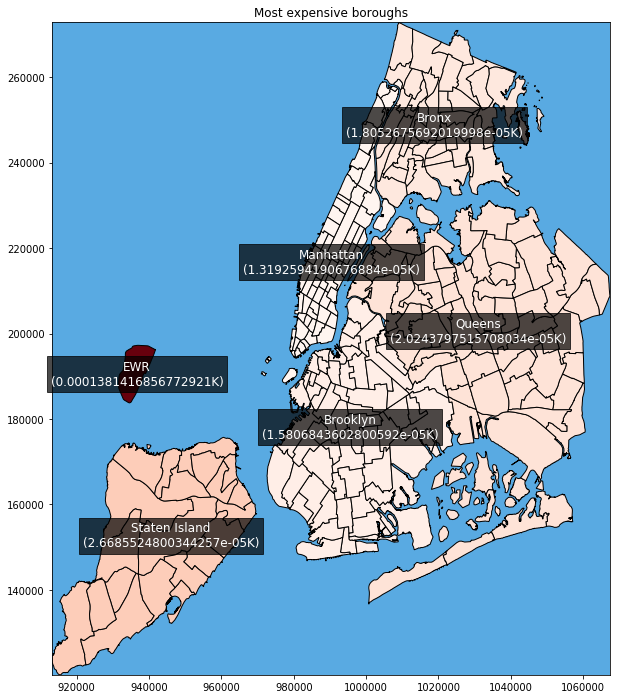

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most expensive boroughs")
draw_region_map(ax, taxiZonesShape, heat = expenseRatio)

### Which region has the most traffic? (tripDuration/tripDistance)

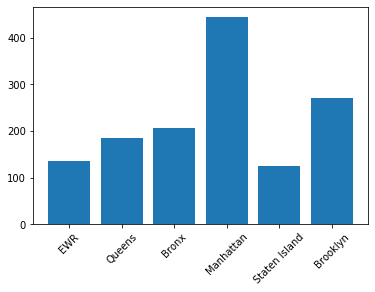

In [109]:
trafficRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    trafficRatio[borough]=totalRideBorough['trip_duration'].sum()/totalRideBorough['trip_distance'].sum()
    
plt.bar(range(len(trafficRatio)), list(trafficRatio.values()), align='center')
plt.xticks(range(len(trafficRatio)), list(trafficRatio.keys()), rotation=45)

plt.show()

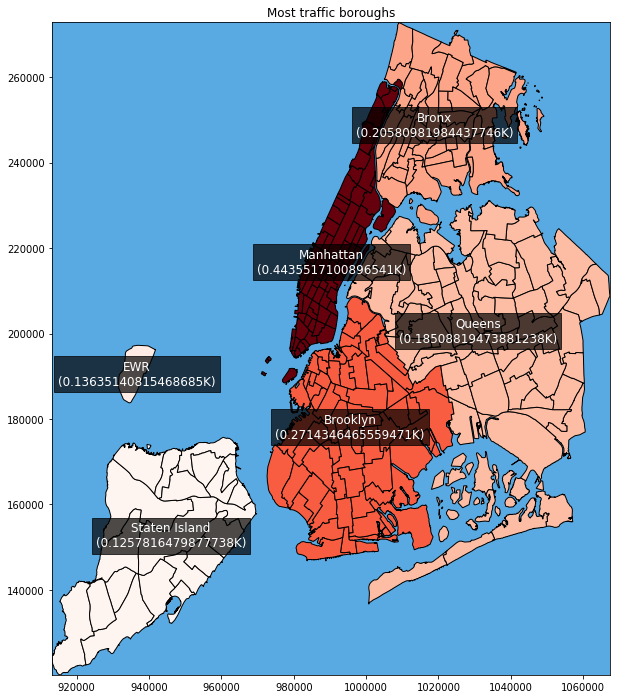

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most traffic boroughs")
draw_region_map(ax, taxiZonesShape, heat = trafficRatio)

In [111]:
print("It took %s seconds to process" % (time.time() - startTime))

It took 78.64736890792847 seconds to process
